In [11]:
import os
import math
import pandas as pd
import concurrent.futures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from glob import glob
import pybedtools
import re
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from scipy import stats
from statsmodels.stats.multitest import multipletests,fdrcorrection
import statsmodels.api as sm
import warnings
from tqdm import tqdm
import pickle
import matplotlib.patches as patches
from upsetplot import plot, from_memberships, from_contents, UpSet
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
warnings.filterwarnings('ignore')
from bootstrapped import bootstrap as bs
import bootstrapped.stats_functions as bs_stats

### Parse DEseq2 results and categorise ASE status by log2 fold change

In [3]:
def categorise_lfc(lfc, padj):
    """
    categorise log2 fold change
    """
    if padj>0.05:
        return "NS"
    elif padj<0.05:
        if abs(lfc)<2:
            return "Diff0"
        if abs(lfc)>=2 and abs(lfc)<=4:
            return "Diff2"
        if abs(lfc)>4:
            return "Diff4"
    elif pd.isna(padj):
        return "NA"
        
def process_deseq2_output(csv, merged_bambu_df):
    """
    parse deseq2 results table that has following columns:
    allele_pair, log2FoldChange, lfcSE, stat, pvalue, padj. 
    """
    df = pd.read_csv(csv)
    df.columns = ["allele_pair"]+list(df.columns)[1:]
    missing = merged_bambu_df[~merged_bambu_df["allele_pair_id"].isin(df["allele_pair"])]
    if not missing.empty:
        missing_rows = pd.DataFrame({
            "allele_pair": missing["allele_pair_id"],
            "log2FoldChange": np.nan,
            "lfcSE": np.nan,
            "stat": np.nan,
            "pvalue": np.nan,
            "padj": np.nan,
            "DEcategory": np.nan
        })
        df = pd.concat([df, missing_rows], ignore_index=True)
    df["DEcategory"] = df.apply(lambda row: categorise_lfc(row["log2FoldChange"], row["padj"]), axis=1)
    return df

In [4]:
merged_bambu_df = pd.read_csv("allele_specific_expression/allele_paired.gene_counts.cds.bambu.tsv", sep="\t")
conditions = ["UG", "4dpi", "6dpi", "8dpi", "10dpi", "12dpi"]
ug_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_UG_b_vs_UG_a.csv", merged_bambu_df)
dpi4_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_4dpi_b_vs_4dpi_a.csv", merged_bambu_df)
dpi6_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_6dpi_b_vs_6dpi_a.csv", merged_bambu_df)
dpi8_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_8dpi_b_vs_8dpi_a.csv", merged_bambu_df)
dpi10_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_10dpi_b_vs_10dpi_a.csv", merged_bambu_df)
dpi12_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_12dpi_b_vs_12dpi_a.csv", merged_bambu_df)

allconditions_DEcategory_df = ug_deseq2_df[["allele_pair", "DEcategory"]].rename(columns={"DEcategory": "UG"}).merge(
    dpi4_deseq2_df[["allele_pair", "DEcategory"]].rename(columns={"DEcategory": "4dpi"}), on="allele_pair", how="outer").merge(
    dpi6_deseq2_df[["allele_pair", "DEcategory"]].rename(columns={"DEcategory": "6dpi"}), on="allele_pair", how="outer").merge(
    dpi8_deseq2_df[["allele_pair", "DEcategory"]].rename(columns={"DEcategory": "8dpi"}), on="allele_pair", how="outer").merge(
    dpi10_deseq2_df[["allele_pair", "DEcategory"]].rename(columns={"DEcategory": "10dpi"}), on="allele_pair", how="outer").merge(
    dpi12_deseq2_df[["allele_pair", "DEcategory"]].rename(columns={"DEcategory": "12dpi"}), on="allele_pair", how="outer")
allconditions_DEcategory_df

,allele_pair,UG,4dpi,6dpi,8dpi,10dpi,12dpi
0,Pst104E137_011008:Pst104E137_026571,Diff4,Diff4,Diff4,Diff4,Diff4,Diff4
1,Pst104E137_014436:Pst104E137_029861,Diff2,NS,NS,NS,Diff0,Diff0
2,Pst104E137_002654:Pst104E137_018166,Diff4,Diff4,Diff4,Diff4,Diff4,Diff4
3,Pst104E137_012361:Pst104E137_027859,Diff2,Diff2,Diff2,Diff2,Diff2,Diff2
4,Pst104E137_013539:Pst104E137_029003,Diff2,Diff2,Diff2,Diff2,Diff2,Diff2
...,...,...,...,...,...,...,...
8117,Pst104E137_004734:Pst104E137_020298,NA,NA,NA,NA,NA,NA
8118,Pst104E137_003368:Pst104E137_018883,NA,NA,NA,NA,NA,NA
8119,Pst104E137_002298:Pst104E137_017860,NA,NA,NA,NA,NA,NA
8120,Pst104E137_001946:Pst104E137_017502,NA,NA,NA,NA,NA,NA


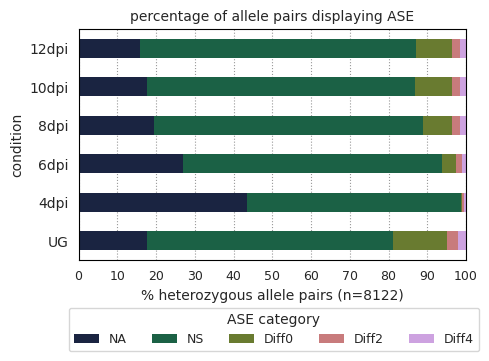

In [5]:
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig,ax = plt.subplots(figsize=(5,3))
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
percentages = allconditions_DEcategory_df.iloc[:,1:].apply(pd.value_counts, normalize=True).T * 100
percentages = percentages[["NA", "NS", "Diff0", "Diff2", "Diff4"]]

colors = sns.color_palette("cubehelix", n_colors=6)
percentages.plot(kind="barh", stacked=True, color=colors, ax=ax, linewidth=0)
plt.xlabel(f"% heterozygous allele pairs (n={len(allconditions_DEcategory_df)})")
plt.ylabel("condition")
plt.title("percentage of allele pairs displaying ASE", fontsize=10)

plt.xlim(0,100)
plt.xticks(ticks=np.arange(0, 101, 10), fontsize=9)
plt.legend(title="ASE category", bbox_to_anchor=(1.05, -0.3), loc="center right", ncol=5, fontsize=9)
plt.savefig("percentage_of_ASE_pairs.svg", format="svg", dpi=600, bbox_inches="tight")

In [6]:
percentages

,NA,NS,Diff0,Diff2,Diff4
UG,17.766560,63.494213,13.728146,2.942625,2.068456
4dpi,43.474514,55.355824,0.233933,0.418616,0.517114
6dpi,26.939178,66.867767,3.681359,1.452844,1.058852
8dpi,19.601083,69.305590,7.559714,1.994583,1.539030
10dpi,17.766560,69.059345,9.554297,1.957646,1.662152
12dpi,15.919724,71.152426,9.418862,1.920709,1.588279


In [151]:
percentages.iloc[:,2:].sum(axis=1)

UG       18.739227
4dpi      1.169663
6dpi      6.193056
8dpi     11.093327
10dpi    13.174095
12dpi    12.927850
dtype: float64

### Upset plot for counting intersections of the five ASE categories

In [8]:
allconditions_DEcategory_df["membership"] = allconditions_DEcategory_df.iloc[:,1:].apply(lambda row: ",".join(list(set(row))), axis=1)
allconditions_DEcategory_df

,allele_pair,UG,4dpi,6dpi,8dpi,10dpi,12dpi,membership
0,Pst104E137_011008:Pst104E137_026571,Diff4,Diff4,Diff4,Diff4,Diff4,Diff4,Diff4
1,Pst104E137_014436:Pst104E137_029861,Diff2,NS,NS,NS,Diff0,Diff0,"Diff2,NS,Diff0"
2,Pst104E137_002654:Pst104E137_018166,Diff4,Diff4,Diff4,Diff4,Diff4,Diff4,Diff4
3,Pst104E137_012361:Pst104E137_027859,Diff2,Diff2,Diff2,Diff2,Diff2,Diff2,Diff2
4,Pst104E137_013539:Pst104E137_029003,Diff2,Diff2,Diff2,Diff2,Diff2,Diff2,Diff2
...,...,...,...,...,...,...,...,...
8117,Pst104E137_004734:Pst104E137_020298,NA,NA,NA,NA,NA,NA,NA
8118,Pst104E137_003368:Pst104E137_018883,NA,NA,NA,NA,NA,NA,NA
8119,Pst104E137_002298:Pst104E137_017860,NA,NA,NA,NA,NA,NA,NA
8120,Pst104E137_001946:Pst104E137_017502,NA,NA,NA,NA,NA,NA,NA


In [9]:
from_memberships(allconditions_DEcategory_df["membership"].str.split(","), data=allconditions_DEcategory_df)

allele_pair     UG  \
Diff0 Diff2 Diff4 NA    NS                                                  
False False True  False False  Pst104E137_011008:Pst104E137_026571  Diff4   
True  True  False False True   Pst104E137_014436:Pst104E137_029861  Diff2   
False False True  False False  Pst104E137_002654:Pst104E137_018166  Diff4   
      True  False False False  Pst104E137_012361:Pst104E137_027859  Diff2   
                        False  Pst104E137_013539:Pst104E137_029003  Diff2   
...                                                            ...    ...   
      False False True  False  Pst104E137_004734:Pst104E137_020298     NA   
                        False  Pst104E137_003368:Pst104E137_018883     NA   
                        False  Pst104E137_002298:Pst104E137_017860     NA   
                        False  Pst104E137_001946:Pst104E137_017502     NA   
                        False  Pst104E137_002884:Pst104E137_018384     NA   

                                4dpi   6dpi   8dpi  10dpi  12dpi  \
Diff0 Diff2 Diff4 NA    NS                                         
False False True  False False  Diff4  Diff4  Diff4  Diff4  Diff4   
True  True  False False True      NS     NS     NS  Diff0  Diff0   
False False True  False False  Diff4  Diff4  Diff4  Diff4  Diff4   
      True  False False False  Diff2  Diff2  Diff2  Diff2  Diff2   
                        False  Diff2  Diff2  Diff2  Diff2  Diff2   
...                              ...    ...    ...    ...    ...   
      False False True  False     NA     NA     NA     NA     NA   
                        False     NA     NA     NA     NA     NA   
                        False     NA     NA     NA     NA     NA   
                        False     NA     NA     NA     NA     NA   
                        False     NA     NA     NA     NA     NA   

                                   membership  
Diff0 Diff2 Diff4 NA    NS                     
False False True  False False           Diff4  
True  True  False False True   Diff2,NS,Diff0  
False False True  False False           Diff4  
      True  False False False           Diff2  
                        False           Diff2  
...                                       ...  
      False False True  False              NA  
                        False              NA  
                        False              NA  
                        False              NA  
                        False              NA  

[8122 rows x 8 columns]

<Figure size 1500x500 with 0 Axes>

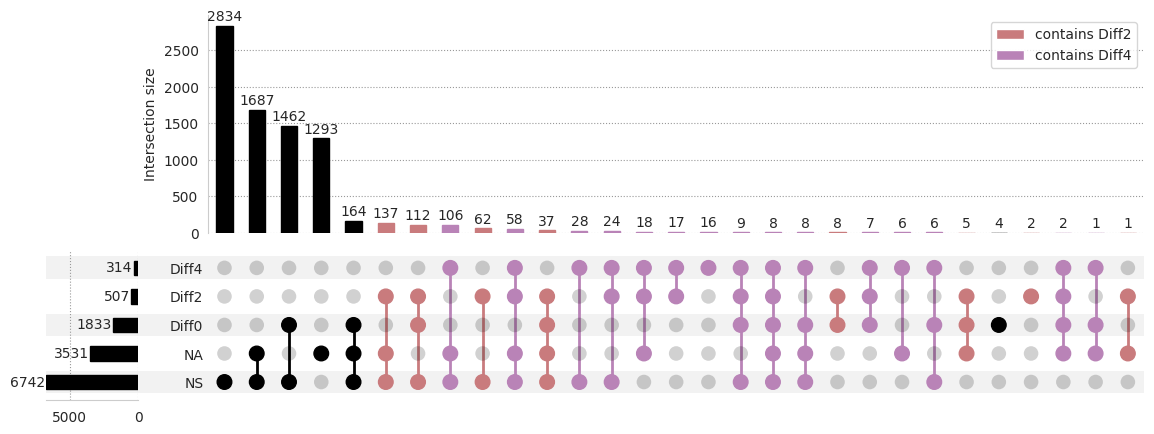

In [12]:
plt.figure(figsize=(15, 5))
upset = UpSet(from_memberships(allconditions_DEcategory_df["membership"].str.split(","), data=allconditions_DEcategory_df),
             element_size=30, show_counts=True, sort_by="cardinality",  intersection_plot_elements=7, totals_plot_elements=3)
upset.style_subsets(present="Diff2", facecolor="#C97B7D", label="contains Diff2")
upset.style_subsets(present="Diff4", facecolor="#B983B7", label="contains Diff4")
upset.plot()
plt.savefig("ASE_upsetplot.svg", format="svg", dpi=600, bbox_inches="tight")

#### Test for balanced expression at genome- and chromosome-wide levels

In [13]:
def obtain_ASE_and_nonASE_pairs(raw_deseq2_df):
    """
    filter raw deseq2 result df to obtain allele pairs displaying allele-specific expression.
    input: df from process_deseq2_output.
    output: two deseq2 dataframe sliced based on ASE or nonASE according to the filter applied.
    """
    df = raw_deseq2_df
    df[["alleleA", "alleleB"]] = df["allele_pair"].str.split(":", expand=True)
    ASE_df = df[(np.absolute(df["log2FoldChange"])>=2)&(df["padj"]<0.05)]
    nonASE_df = df[~(np.absolute(df["log2FoldChange"])>=2)|~(df["padj"]<0.05)]
    return ASE_df, nonASE_df

def filter_genes_by_ASE_status(ase_status_df, query_gene_list, ase_status):
    assert ase_status == "ASE" or ase_status == "nonASE"
    ase_status_allele_pairs = ase_status_df["allele_pair"].tolist()
    result_pairs = []
    for gene_pair in ase_status_allele_pairs:
        geneA, geneB = gene_pair.split(":")
        if geneA in query_gene_list or geneB in query_gene_list:
            result_pairs.append(gene_pair)
    print(f"# of queried allele pairs in the {ase_status} category: {len(result_pairs)} ({len(result_pairs)*2} genes)")
    print(f"percentage of queried allele pairs out of all pairs in the {ase_status} category:\n{len(result_pairs)}/{len(ase_status_allele_pairs)} = {len(result_pairs)/len(ase_status_allele_pairs)}")
    return result_pairs, len(result_pairs)

def remove_overlaps(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    unique_list1 = list(set1 - set2)  # elements in list1 but not in list2
    unique_list2 = list(set2 - set1)  # elements in list2 but not in list1
    return unique_list1, unique_list2

def get_gene_id(faa):
    """
    get gene ID from faa headers' second field
    """
    out = []
    with open(faa, "r") as file:
        for n in file.readlines():
            if n.startswith(">"):
                out.append(n.split(" ")[-1].rstrip())
    return out

def log_transform_norm_count(df):
    df.reset_index(inplace=True)
    df = pd.melt(df, id_vars=["index"])
    df["log10(median_or_ratio+1)"] = np.log10(df["value"]+1)
    return df

Get absolute and normalised transcript counts for global genes

In [142]:
all_genes_count_df = pd.read_csv("allele_specific_expression/all_cond.gene_counts.cds.bambu.tsv", sep="\t")

# filter to keep genes (rows) that have at least four instances that have transcript counts greater than 5
filt_genes_count_df = all_genes_count_df[all_genes_count_df.iloc[:,1:].gt(5).sum(axis=1) >= 4]
filt_gene_ids = filt_genes_count_df["GENEID"].tolist()

# load deseq2-normalised transcript abundances for protein-coding gene models that show expression (defined above)
all_genes_norm_count_df = pd.read_csv("allele_specific_expression/all_cond.cds.bambu_DESeq2_norm_counts.tsv", sep="\t").reset_index()
filt_genes_norm_count_df = all_genes_norm_count_df[all_genes_norm_count_df["index"].isin(filt_gene_ids)]
filt_genes_norm_count_df

,index,Pst104E_U_UG_rep1,Pst104E_U_UG_rep2,Pst104E_U_UG_rep3,Pst104E_U_UG_rep4,Pst104E_U_4dpi_rep1,Pst104E_U_4dpi_rep2,Pst104E_U_4dpi_rep3,Pst104E_U_4dpi_rep4,Pst104E_U_6dpi_rep1,...,Pst104E_U_8dpi_rep3,Pst104E_U_8dpi_rep4,Pst104E_U_10dpi_rep1,Pst104E_U_10dpi_rep2,Pst104E_U_10dpi_rep3,Pst104E_U_10dpi_rep4,Pst104E_U_12dpi_rep1,Pst104E_U_12dpi_rep2,Pst104E_U_12dpi_rep3,Pst104E_U_12dpi_rep4
0,Pst104E137_000001,8.313913,6.560710,7.215480,8.857669,0.000000,11.549665,0.000000,0.000000,8.317870,...,0.506504,2.848280,0.929952,1.412527,1.860503,1.091305,1.406772,0.000000,1.748192,3.328307
1,Pst104E137_000002,8.005990,7.185539,8.297803,9.490360,19.278352,23.099331,0.000000,0.000000,8.317870,...,14.182112,7.595414,10.849439,17.892009,11.473105,12.822835,5.064380,9.272865,7.866864,4.807555
2,Pst104E137_000003,49.575556,45.300137,58.806166,53.778705,19.278352,80.847658,8.489212,17.703044,16.635740,...,57.741454,56.965603,47.737531,55.559396,57.365523,63.841349,72.308091,64.468491,58.127383,64.162368
5,Pst104E137_000006,0.000000,0.312415,0.721548,0.632691,0.000000,0.000000,8.489212,0.000000,16.635740,...,23.299183,28.482801,13.949279,20.717063,13.643692,11.458704,9.566051,18.104165,18.356016,11.649075
6,Pst104E137_000007,0.000000,0.000000,0.000000,0.000000,0.000000,23.099331,0.000000,17.703044,33.271481,...,8.104064,3.797707,1.859904,2.354212,5.891594,1.364131,2.813544,3.532520,1.748192,6.656615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30074,Pst104E137_031058,23.710049,31.553889,29.222696,16.766302,19.278352,57.748327,42.446062,35.406087,16.635740,...,32.416255,53.167896,23.868766,33.900648,34.729398,35.740243,31.793052,37.974590,31.467456,24.962305
30075,Pst104E137_031059,32.947730,39.364257,40.045917,30.369151,327.731988,173.244981,254.676375,212.436523,207.946755,...,359.617830,420.596035,309.364002,347.952488,304.192312,281.556720,353.943884,308.653939,306.370644,313.415601
30076,Pst104E137_031060,14.164445,18.432470,20.203345,17.715338,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.949427,4.959744,2.825054,4.341175,6.820657,9.284696,7.065040,4.807528,7.950956
30077,Pst104E137_031061,3.387150,2.186903,3.607740,0.632691,0.000000,0.000000,0.000000,0.000000,83.178702,...,71.923566,53.167896,56.107099,46.142549,54.884851,50.472862,45.579419,36.208330,43.704799,36.611380


In [143]:
# v2 het biallelic genes only

paired_alleles_count_df = pd.read_csv("allele_specific_expression/allele_paired.gene_counts.cds.bambu.tsv", sep="\t")
paired_allele_ids = [x.split(":") for x in paired_alleles_count_df["allele_pair_id"].tolist()]
a_gene_id = [sublist[0] for sublist in paired_allele_ids]
b_gene_id = [sublist[1] for sublist in paired_allele_ids]
# first split filtered genes normalised counts df into haplotypes
a_filt_genes_norm_count_df = filt_genes_norm_count_df[filt_genes_norm_count_df["index"].isin(a_gene_id)]
b_filt_genes_norm_count_df = filt_genes_norm_count_df[filt_genes_norm_count_df["index"].isin(b_gene_id)]
# since the normalised count df has been filtered, some pairs would have one allele filtered out and become unpaired
# find the common alleles that still can be paired after filtering
common_pairs = [pair for pair in paired_allele_ids if pair[0] in a_filt_genes_norm_count_df["index"].tolist() and pair[1] in b_filt_genes_norm_count_df["index"].tolist()]
a_common_ids = [pair[0] for pair in common_pairs]
b_common_ids = [pair[1] for pair in common_pairs]
# filter the haplotype table again
a_filt_genes_norm_count_df = filt_genes_norm_count_df[filt_genes_norm_count_df["index"].isin(a_common_ids)].set_index("index")
b_filt_genes_norm_count_df = filt_genes_norm_count_df[filt_genes_norm_count_df["index"].isin(b_common_ids)].set_index("index")
a_transformed_norm_count = log_transform_norm_count(a_filt_genes_norm_count_df)
b_transformed_norm_count = log_transform_norm_count(b_filt_genes_norm_count_df)
# check if length is the same
assert len(a_transformed_norm_count) == len(b_transformed_norm_count)
a_transformed_norm_count["haplotype"] = "A"
b_transformed_norm_count["haplotype"] = "B"
# put them back together for plotting
filt_genes_transformed_norm_count = pd.concat([a_transformed_norm_count, b_transformed_norm_count], axis=0)
filt_genes_transformed_norm_count["condition"] = filt_genes_transformed_norm_count["variable"].apply(lambda x: x.split("_rep")[0])
filt_genes_transformed_norm_count = filt_genes_transformed_norm_count.groupby(["index","condition", "haplotype"])["value"].mean().reset_index()
filt_genes_transformed_norm_count["log10(median_or_ratio+1)"] = np.log10(filt_genes_transformed_norm_count["value"]+1)
print(f"# of allele pairs considered: {len(filt_genes_transformed_norm_count['index'].unique())/2}")
filt_genes_transformed_norm_count

# of allele pairs considered: 5896.0


,index,condition,haplotype,value,log10(median_or_ratio+1)
0,Pst104E137_000003,Pst104E_U_10dpi,A,56.125950,1.756833
1,Pst104E137_000003,Pst104E_U_12dpi,A,64.766583,1.818005
2,Pst104E137_000003,Pst104E_U_4dpi,A,31.579566,1.512945
3,Pst104E137_000003,Pst104E_U_6dpi,A,50.032235,1.707845
4,Pst104E137_000003,Pst104E_U_8dpi,A,64.781100,1.818101
...,...,...,...,...,...
70747,Pst104E137_031062,Pst104E_U_12dpi,B,21.341645,1.349115
70748,Pst104E137_031062,Pst104E_U_4dpi,B,40.679008,1.619917
70749,Pst104E137_031062,Pst104E_U_6dpi,B,31.098339,1.506483
70750,Pst104E137_031062,Pst104E_U_8dpi,B,39.486394,1.607309


In [120]:
# expression_ratio_df = []
# for pair in common_pairs:
#     hapA = filt_genes_transformed_norm_count.loc[filt_genes_transformed_norm_count["index"] == pair[0], :]
#     hapB = filt_genes_transformed_norm_count.loc[filt_genes_transformed_norm_count["index"] == pair[1], :]
#     combined = pd.concat([hapA, hapB], axis=0)
#     pivot_combined = combined.pivot(index="condition", columns="haplotype", values="log10(median_or_ratio+1)")
#     if "A" in pivot_combined.columns and "B" in pivot_combined.columns:
#         pivot_combined["ratio_a:b"] = pivot_combined["A"] / pivot_combined["B"]
#         expression_ratio_df.append(pivot_combined[["A", "B", "ratio_a:b"]])
# expression_ratio_df = pd.concat(expression_ratio_df, keys=[f"{pair[0]}:{pair[1]}" for pair in common_pairs], names=["pair", "condition"]).reset_index()
# expression_ratio_df["condition"] = expression_ratio_df["condition"].apply(lambda x: x.split("_")[-1])
# len(expression_ratio_df)

# allconditions_DEcategory_df_melted = allconditions_DEcategory_df.melt(id_vars=["allele_pair"], 
#                                             value_vars=["UG", "4dpi", "6dpi", "8dpi", "10dpi", "12dpi"], 
#                                             var_name="condition", 
#                                             value_name="ASE_status")
# expression_ratio_df = pd.merge(expression_ratio_df, allconditions_DEcategory_df_melted, 
#                      left_on=["pair", "condition"], 
#                      right_on=["allele_pair", "condition"], 
#                      how="left")
# expression_ratio_df["colour"] = np.where(expression_ratio_df["ASE_status"].isin(["Diff2", "Diff4"]), "red", "black")
# expression_ratio_df = expression_ratio_df.dropna()
# expression_ratio_df

# sns.set_style("white")
# fig = plt.figure(figsize=(4,4))
# plt.margins(x=0, y=0)
# palette = {"red": "red", "black": "black"}
# sns.scatterplot(data=expression_ratio_df, x="A", y="B", s=2, hue="colour", palette=palette,alpha=0.5, linewidth=0)

# xlim = plt.xlim()
# ylim = plt.ylim()

# plt.plot([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])], 
#          [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])], 
#          linestyle="--", color="gray", linewidth=0.8)

# plt.tight_layout()
# plt.show()

In [144]:
a_transformed_norm_count = filt_genes_transformed_norm_count[filt_genes_transformed_norm_count["haplotype"]=="A"]
b_transformed_norm_count = filt_genes_transformed_norm_count[filt_genes_transformed_norm_count["haplotype"]=="B"]
a_vals = np.array(a_transformed_norm_count["log10(median_or_ratio+1)"])
b_vals = np.array(b_transformed_norm_count["log10(median_or_ratio+1)"])
print(f"# of values in a: {len(a_vals)}\n# of values in b: {len(b_vals)}")

# test if the transformed normalisation count values are normally distributed.
for array in [a_vals, b_vals]:
    stat, pvalue = stats.normaltest(array)
    print(f"normality test stats: {stat}, pvalue: {pvalue}")
    if pvalue < 0.05:
        print("normality test pvalue < 0.05, reject null. not normally distributed.")
        
# since both arrays do not follow normality, use the nonparametric mann whitney test.
mwstat, pval = stats.mannwhitneyu(a_vals, b_vals)
print(f"\nMannWhiteneyU stats: {mwstat}, pvalue: {pval}")
if pval < 0.05:
    print("pvalue < 0.05, reject null.")
else:
    print("pvalue >= 0.05, accept null.")

print(np.median(a_vals))
print(np.median(b_vals))

# of values in a: 35376
# of values in b: 35376
normality test stats: 228.64748497403775, pvalue: 2.2378423447055123e-50
normality test pvalue < 0.05, reject null. not normally distributed.
normality test stats: 228.03381848934745, pvalue: 3.041483546289701e-50
normality test pvalue < 0.05, reject null. not normally distributed.

MannWhiteneyU stats: 640880642.5, pvalue: 2.4374779389607945e-08
pvalue < 0.05, reject null.
1.3612779150329617
1.335844530373914


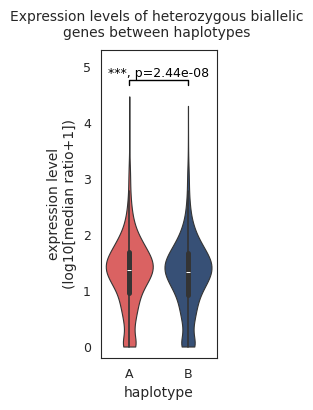

In [145]:
sns.set_style("white")
fig,ax = plt.subplots(1,1,figsize=(1.5,4))
color=["#ee4e4e", "#2c4e80"]
palette = {"A": color[0], "B": color[1]}
#ax[0]
sns.violinplot(pd.concat([a_transformed_norm_count, b_transformed_norm_count], axis=0), y="log10(median_or_ratio+1)", 
               x="haplotype", ax=ax, 
               
               linewidth=0.8, palette=palette, cut=0, bw_adjust=2)
ax.set_ylabel("expression level\n(log10[median ratio+1])")
ax.set_xlabel("haplotype")
ax.tick_params(axis='both', labelsize=9)

x1,x2 = 0,1
y,h,col = filt_genes_transformed_norm_count["log10(median_or_ratio+1)"].max() + 0.2,0.1,"k"
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
ax.set_ylim(-0.2,5.3)
if pval>0.05:
    ax.text((x1+x2)*.5, y+h, "NS", ha='center', va='bottom', color=col, fontsize=9)
else:
    ax.text((x1+x2)*.5, y+h, f"***, p={pval:.2e}", ha='center', va='bottom', color=col, fontsize=9)
plt.suptitle("Expression levels of heterozygous biallelic\ngenes between haplotypes", size=10, y=0.98)
plt.savefig("expression_level_het_genes_btwn_haplotypes.svg", format="svg", dpi=600, bbox_inches="tight")
plt.show()

In [146]:
#whole genome genes

HAPA_PROT = "allele_specific_expression/Puccinia_striiformis_Pst104E_hapA.proteins.fa"
HAPB_PROT = "allele_specific_expression/Puccinia_striiformis_Pst104E_hapB.proteins.fa"
a_gene_id = get_gene_id(HAPA_PROT)
b_gene_id = get_gene_id(HAPB_PROT)
a_all_genes_norm_count_df = filt_genes_norm_count_df[filt_genes_norm_count_df["index"].isin(a_gene_id)].set_index("index")
b_all_genes_norm_count_df = filt_genes_norm_count_df[filt_genes_norm_count_df["index"].isin(b_gene_id)].set_index("index")
a_transformed_norm_count = log_transform_norm_count(a_all_genes_norm_count_df)
b_transformed_norm_count = log_transform_norm_count(b_all_genes_norm_count_df)
a_transformed_norm_count["haplotype"] = "A"
b_transformed_norm_count["haplotype"] = "B"
# put them back together for plotting
all_genes_transformed_norm_count = pd.concat([a_transformed_norm_count, b_transformed_norm_count], axis=0)
all_genes_transformed_norm_count["condition"] = all_genes_transformed_norm_count["variable"].apply(lambda x: x.split("_rep")[0])
all_genes_transformed_norm_count = all_genes_transformed_norm_count.groupby(["index","condition", "haplotype"])["value"].mean().reset_index()
all_genes_transformed_norm_count["log10(median_or_ratio+1)"] = np.log10(all_genes_transformed_norm_count["value"]+1)
print(f"# of paired alleles considered: {len(all_genes_transformed_norm_count['index'].unique())}")
all_genes_transformed_norm_count

# of paired alleles considered: 19346


,index,condition,haplotype,value,log10(median_or_ratio+1)
0,Pst104E137_000001,Pst104E_U_10dpi,A,1.323572,0.366156
1,Pst104E137_000001,Pst104E_U_12dpi,A,1.620818,0.418437
2,Pst104E137_000001,Pst104E_U_4dpi,A,2.887416,0.589661
3,Pst104E137_000001,Pst104E_U_6dpi,A,2.079468,0.488476
4,Pst104E137_000001,Pst104E_U_8dpi,A,1.117356,0.325794
...,...,...,...,...,...
116071,Pst104E137_031062,Pst104E_U_12dpi,B,21.341645,1.349115
116072,Pst104E137_031062,Pst104E_U_4dpi,B,40.679008,1.619917
116073,Pst104E137_031062,Pst104E_U_6dpi,B,31.098339,1.506483
116074,Pst104E137_031062,Pst104E_U_8dpi,B,39.486394,1.607309


In [147]:
a_transformed_norm_count = all_genes_transformed_norm_count[all_genes_transformed_norm_count["haplotype"]=="A"]
b_transformed_norm_count = all_genes_transformed_norm_count[all_genes_transformed_norm_count["haplotype"]=="B"]
a_vals = np.array(a_transformed_norm_count["log10(median_or_ratio+1)"])
b_vals = np.array(b_transformed_norm_count["log10(median_or_ratio+1)"])
print(f"# of values in a: {len(a_vals)}\n# of values in b: {len(b_vals)}")

# test if the transformed normalisation count values are normally distributed.
for array in [a_vals, b_vals]:
    stat, pvalue = stats.normaltest(array)
    print(f"normality test stats: {stat}, pvalue: {pvalue}")
    if pvalue < 0.05:
        print("normality test pvalue < 0.05, reject null. not normally distributed.")
        
# since both arrays do not follow normality, use the nonparametric mann whitney test.
mwstat, pval = stats.mannwhitneyu(a_vals, b_vals)
print(f"\nMannWhiteneyU stats: {mwstat}, pvalue: {pval}")
if pval < 0.05:
    print("pvalue < 0.05, reject null.")
else:
    print("pvalue >= 0.05, accept null.")

print(np.median(a_vals))
print(np.median(b_vals))

# of values in a: 58602
# of values in b: 57474
normality test stats: 180.40392057531935, pvalue: 6.695552045319198e-40
normality test pvalue < 0.05, reject null. not normally distributed.
normality test stats: 226.42171176404383, pvalue: 6.810045269754484e-50
normality test pvalue < 0.05, reject null. not normally distributed.

MannWhiteneyU stats: 1694289504.5, pvalue: 0.07264536728085426
pvalue >= 0.05, accept null.
1.2537978545679906
1.2444880603004058


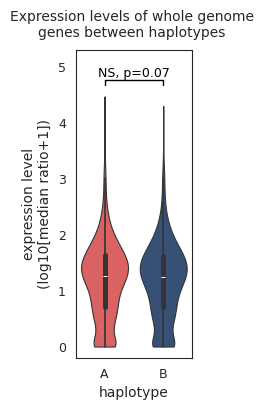

In [150]:
sns.set_style("white")
fig,ax = plt.subplots(1,1,figsize=(1.5,4))
color=["#ee4e4e", "#2c4e80"]
palette = {"A": color[0], "B": color[1]}
#ax[0]
sns.violinplot(pd.concat([a_transformed_norm_count, b_transformed_norm_count], axis=0), y="log10(median_or_ratio+1)", 
               x="haplotype", ax=ax, 
               
               linewidth=0.8, palette=palette, cut=0, bw_adjust=2)
ax.set_ylabel("expression level\n(log10[median ratio+1])")
ax.set_xlabel("haplotype")
ax.tick_params(axis='both', labelsize=9)

x1,x2 = 0,1
y,h,col = all_genes_transformed_norm_count["log10(median_or_ratio+1)"].max() + 0.2,0.1,"k"
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
ax.set_ylim(-0.2,5.3)
if pval>0.05:
    ax.text((x1+x2)*.5, y+h, f"NS, p={pval:.2f}", ha='center', va='bottom', color=col, fontsize=9)
else:
    ax.text((x1+x2)*.5, y+h, f"***, p={pval:.2e}", ha='center', va='bottom', color=col, fontsize=9)
plt.suptitle("Expression levels of whole genome\ngenes between haplotypes", size=10, y=0.98)
plt.savefig("expression_level_genome_wide_genes_btwn_haplotypes.svg", format="svg", dpi=600, bbox_inches="tight")
plt.show()

### secretome gene enrichment in ASE set

1. ASE definition: p<0.05, |lfc| >= 2.
2. 

In [155]:
# reload DEseq2 results from filtered data
# only four instances where any allele has transcript counts more than 5
# ug_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_UG_b_vs_UG_a.csv", merged_bambu_df)
# dpi4_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_4dpi_b_vs_4dpi_a.csv", merged_bambu_df)
# dpi6_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_6dpi_b_vs_6dpi_a.csv", merged_bambu_df)
# dpi8_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_8dpi_b_vs_8dpi_a.csv", merged_bambu_df)
# dpi10_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_10dpi_b_vs_10dpi_a.csv", merged_bambu_df)
# dpi12_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_12dpi_b_vs_12dpi_a.csv", merged_bambu_df)
ug_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table_filtered_lowcounts/condition_UG_b_vs_UG_a.csv", merged_bambu_df).dropna()
dpi4_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table_filtered_lowcounts/condition_4dpi_b_vs_4dpi_a.csv", merged_bambu_df).dropna()
dpi6_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table_filtered_lowcounts/condition_6dpi_b_vs_6dpi_a.csv", merged_bambu_df).dropna()
dpi8_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table_filtered_lowcounts/condition_8dpi_b_vs_8dpi_a.csv", merged_bambu_df).dropna()
dpi10_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table_filtered_lowcounts/condition_10dpi_b_vs_10dpi_a.csv", merged_bambu_df).dropna()
dpi12_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table_filtered_lowcounts/condition_12dpi_b_vs_12dpi_a.csv", merged_bambu_df).dropna()

In [156]:
ug_ASE, ug_nonASE = obtain_ASE_and_nonASE_pairs(ug_deseq2_df)
dpi4_ASE, dpi4_nonASE = obtain_ASE_and_nonASE_pairs(dpi4_deseq2_df)
dpi6_ASE, dpi6_nonASE = obtain_ASE_and_nonASE_pairs(dpi6_deseq2_df)
dpi8_ASE, dpi8_nonASE = obtain_ASE_and_nonASE_pairs(dpi8_deseq2_df)
dpi10_ASE, dpi10_nonASE = obtain_ASE_and_nonASE_pairs(dpi10_deseq2_df)
dpi12_ASE, dpi12_nonASE = obtain_ASE_and_nonASE_pairs(dpi12_deseq2_df)

In [157]:
# all_genes_count_df = pd.read_csv("allele_specific_expression/all_cond.gene_counts.cds.bambu.tsv", sep="\t")
# target_gene_ids = all_genes_count_df["GENEID"].tolist()

# load complete busco gene id
busco_df = pd.read_csv("ase_functional_enrichment/busco/busco_full_table.csv", sep="\t", header=None)
busco_df.columns = "Busco_id      Status  Sequence        Score   Length  OrthoDB_url     Description".split()
busco_df = busco_df[busco_df["Status"] == "Complete"]
busco_df["Sequence"] = busco_df["Sequence"].apply(lambda x: x[:-3])
busco_gene_id = busco_df["Sequence"].tolist()

# load secretome/effector gff3
seceff_df = pd.read_csv("secretome_effector_candidates/Puccinia_striiformis_Pst104E.secretome-effectors.TM_anno_cleaned.mRNA.gff3", sep="\t", header=None)
seceff_df.columns = ["chr", "method", "type", "start", "end", "strand", "func_anno", "gene_id"]
seceff_gene_id = seceff_df["gene_id"].tolist()
print(f"number of total gene ids:\nsecretome - {len(seceff_gene_id)}\nbusco - {len(busco_gene_id)}\n")

# some secretome genes are buscos. 
# remove overlaps between busco and secretome/effector genes.
seceff_gene_id, busco_gene_id = remove_overlaps(seceff_gene_id, busco_gene_id)
print(f"number of filtered gene ids after removing overlaps:\n secreomte/effectors: {len(seceff_gene_id)}, busco: {len(busco_gene_id)}")

# need to consider heterozygous
seceff_gene_id = [x for x in seceff_gene_id if x in a_gene_id+b_gene_id]
busco_gene_id = [x for x in busco_gene_id if x in a_gene_id+b_gene_id]
print(f"number of filtered gene ids after filtered based on paired info:\n secreomte/effectors: {len(seceff_gene_id)}, busco: {len(busco_gene_id)}")

number of total gene ids:
secretome - 4537
busco - 3122

number of filtered gene ids after removing overlaps:
 secreomte/effectors: 4511, busco: 3096
number of filtered gene ids after filtered based on paired info:
 secreomte/effectors: 4511, busco: 3096


In [158]:
print("### BUSCO ###")
print("UG")
busco_ug_ASE_genes, busco_ug_ASE_genes_num = filter_genes_by_ASE_status(ug_ASE, busco_gene_id, "ASE")
busco_ug_nonASE_genes, busco_ug_nonASE_genes_num = filter_genes_by_ASE_status(ug_nonASE, busco_gene_id, "nonASE")
print("\n4dpi")
busco_dpi4_ASE_genes, busco_dpi4_ASE_genes_num = filter_genes_by_ASE_status(dpi4_ASE, busco_gene_id, "ASE")
busco_dpi4_nonASE_genes, busco_dpi4_nonASE_genes_num = filter_genes_by_ASE_status(dpi4_nonASE, busco_gene_id, "nonASE")
print("\n6dpi")
busco_dpi6_ASE_genes, busco_dpi6_ASE_genes_num = filter_genes_by_ASE_status(dpi6_ASE, busco_gene_id, "ASE")
busco_dpi6_nonASE_genes, busco_dpi6_nonASE_genes_num = filter_genes_by_ASE_status(dpi6_nonASE, busco_gene_id, "nonASE")
print("\n8dpi")
busco_dpi8_ASE_genes, busco_dpi8_ASE_genes_num = filter_genes_by_ASE_status(dpi8_ASE, busco_gene_id, "ASE")
busco_dpi8_nonASE_genes, busco_dpi8_nonASE_genes_num = filter_genes_by_ASE_status(dpi8_nonASE, busco_gene_id, "nonASE")
print("\n10dpi")
busco_dpi10_ASE_genes, busco_dpi10_ASE_genes_num = filter_genes_by_ASE_status(dpi10_ASE, busco_gene_id, "ASE")
busco_dpi10_nonASE_genes, busco_dpi10_nonASE_genes_num = filter_genes_by_ASE_status(dpi10_nonASE, busco_gene_id, "nonASE")
print("\n12dpi")
busco_dpi12_ASE_genes, busco_dpi12_ASE_genes_num = filter_genes_by_ASE_status(dpi12_ASE, busco_gene_id, "ASE")
busco_dpi12_nonASE_genes, busco_dpi12_nonASE_genes_num = filter_genes_by_ASE_status(dpi12_nonASE, busco_gene_id, "nonASE")

# secretome/effector genes that show ASE or nonASE, at ug and 12dpi
print("\n------------\n### SECRETOME/EFFECTORS ###")
print("UG")
seceff_ug_ASE_genes, seceff_ug_ASE_genes_num = filter_genes_by_ASE_status(ug_ASE, seceff_gene_id, "ASE")
seceff_ug_nonASE_genes, seceff_ug_nonASE_genes_num = filter_genes_by_ASE_status(ug_nonASE, seceff_gene_id, "nonASE")
print("\n4dpi")
seceff_dpi4_ASE_genes, seceff_dpi4_ASE_genes_num = filter_genes_by_ASE_status(dpi4_ASE, seceff_gene_id, "ASE")
seceff_dpi4_nonASE_genes, seceff_dpi4_nonASE_genes_num = filter_genes_by_ASE_status(dpi4_nonASE, seceff_gene_id, "nonASE")
print("\n6dpi")
seceff_dpi6_ASE_genes, seceff_dpi6_ASE_genes_num = filter_genes_by_ASE_status(dpi6_ASE, seceff_gene_id, "ASE")
seceff_dpi6_nonASE_genes, seceff_dpi6_nonASE_genes_num = filter_genes_by_ASE_status(dpi6_nonASE, seceff_gene_id, "nonASE")
print("\n8dpi")
seceff_dpi8_ASE_genes, seceff_dpi8_ASE_genes_num = filter_genes_by_ASE_status(dpi8_ASE, seceff_gene_id, "ASE")
seceff_dpi8_nonASE_genes, seceff_dpi8_nonASE_genes_num = filter_genes_by_ASE_status(dpi8_nonASE, seceff_gene_id, "nonASE")
print("\n10dpi")
seceff_dpi10_ASE_genes, seceff_dpi10_ASE_genes_num = filter_genes_by_ASE_status(dpi10_ASE, seceff_gene_id, "ASE")
seceff_dpi10_nonASE_genes, seceff_dpi10_nonASE_genes_num = filter_genes_by_ASE_status(dpi10_nonASE, seceff_gene_id, "nonASE")
print("\n12dpi")
seceff_dpi12_ASE_genes, seceff_dpi12_ASE_genes_num = filter_genes_by_ASE_status(dpi12_ASE, seceff_gene_id, "ASE")
seceff_dpi12_nonASE_genes, seceff_dpi12_nonASE_genes_num = filter_genes_by_ASE_status(dpi12_nonASE, seceff_gene_id, "nonASE")

### BUSCO ###
UG
# of queried allele pairs in the ASE category: 14 (28 genes)
percentage of queried allele pairs out of all pairs in the ASE category:
14/406 = 0.034482758620689655
# of queried allele pairs in the nonASE category: 1197 (2394 genes)
percentage of queried allele pairs out of all pairs in the nonASE category:
1197/6051 = 0.19781854238968766

4dpi
# of queried allele pairs in the ASE category: 9 (18 genes)
percentage of queried allele pairs out of all pairs in the ASE category:
9/74 = 0.12162162162162163
# of queried allele pairs in the nonASE category: 1189 (2378 genes)
percentage of queried allele pairs out of all pairs in the nonASE category:
1189/4881 = 0.24359762343782013

6dpi
# of queried allele pairs in the ASE category: 12 (24 genes)
percentage of queried allele pairs out of all pairs in the ASE category:
12/205 = 0.05853658536585366
# of queried allele pairs in the nonASE category: 1198 (2396 genes)
percentage of queried allele pairs out of all pairs in the nonAS

In [159]:
# H0: Gene category is independent upon ASE status.
# Ha: Gene category is not independent upon ASE status.

results_dir = {}

print("UG")
contingency_table = np.array([[seceff_ug_ASE_genes_num, busco_ug_ASE_genes_num],\
                              [seceff_ug_nonASE_genes_num, busco_ug_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["UG"] = fisher_res

print("4dpi")
contingency_table = np.array([[seceff_dpi4_ASE_genes_num, busco_dpi4_ASE_genes_num],\
                              [seceff_dpi4_nonASE_genes_num, busco_dpi4_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["4dpi"] = fisher_res

print("6dpi")
contingency_table = np.array([[seceff_dpi6_ASE_genes_num, busco_dpi6_ASE_genes_num],\
                              [seceff_dpi6_nonASE_genes_num, busco_dpi6_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["6dpi"] = fisher_res

print("8dpi")
contingency_table = np.array([[seceff_dpi8_ASE_genes_num, busco_dpi8_ASE_genes_num],\
                              [seceff_dpi8_nonASE_genes_num, busco_dpi8_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["8dpi"] = fisher_res

print("10dpi")
contingency_table = np.array([[seceff_dpi10_ASE_genes_num, busco_dpi10_ASE_genes_num],\
                              [seceff_dpi10_nonASE_genes_num, busco_dpi10_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["10dpi"] = fisher_res

print("12dpi")
contingency_table = np.array([[seceff_dpi12_ASE_genes_num, busco_dpi12_ASE_genes_num],\
                              [seceff_dpi12_nonASE_genes_num, busco_dpi12_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["12dpi"] = fisher_res

fisher_res_df = pd.DataFrame.from_dict(results_dir, orient='index', columns=['odds ratio', 'pval']).reset_index()
rejected, pvals_corrected, _, _ = multipletests(fisher_res_df["pval"], method="fdr_bh")
fisher_res_df["corr_pval"] = pvals_corrected
fisher_res_df['-log10(p-value)'] = -np.log10(pvals_corrected)
fisher_res_df.columns = ["condition", "odds ratio", "pval", "corr_pval", "-log10(p-value)"]
fisher_res_df["isSigf"] = np.where(fisher_res_df["-log10(p-value)"]>-(np.log10(0.05)), "yes", "no")
fisher_res_df

UG
(11.048913043478262, 4.623144314055037e-26)
4dpi
(4.426403207331043, 0.000662407662005486)
6dpi
(6.393983503153809, 3.498567006501961e-10)
8dpi
(9.991666666666667, 4.175297819143814e-20)
10dpi
(15.030565583634175, 3.827123836790047e-28)
12dpi
(14.575458020297878, 8.68425231075341e-25)


,condition,odds ratio,pval,corr_pval,-log10(p-value),isSigf
0,UG,11.048913,4.623144e-26,1.386943e-25,24.857941,yes
1,4dpi,4.426403,6.624077e-04,6.624077e-04,3.178875,yes
2,6dpi,6.393984,3.498567e-10,4.198280e-10,9.376929,yes
3,8dpi,9.991667,4.175298e-20,6.262947e-20,19.203221,yes
4,10dpi,15.030566,3.827124e-28,2.296274e-27,26.638976,yes
5,12dpi,14.575458,8.684252e-25,1.736850e-24,23.760238,yes


<Figure size 640x480 with 0 Axes>

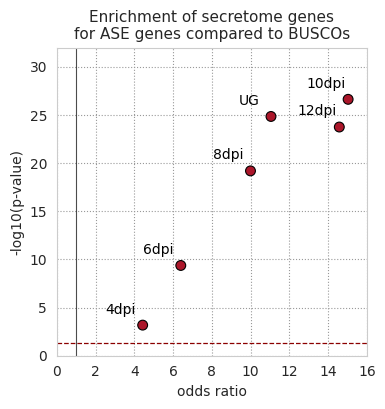

In [160]:
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.despine(left=True)
palette = list(sns.color_palette("RdBu",10))
palette = [palette[0],"darkgrey"]
plt.figure(figsize=(4,4))
sns.scatterplot(fisher_res_df, x="odds ratio", y="-log10(p-value)", hue="isSigf", s=50, palette=palette, legend=False, linewidth=0.8, edgecolor="black")
for i in range(fisher_res_df.shape[0]):
    plt.text(fisher_res_df["odds ratio"][i]-1.15, fisher_res_df["-log10(p-value)"][i]+1.2, fisher_res_df["condition"][i], 
             horizontalalignment="center", color="black", fontsize=10)

plt.axhline(y=-np.log10(0.05), color="darkred", linestyle='--', linewidth=0.9)
plt.axvline(x=1, color="black", linewidth=0.8, alpha=0.7)
plt.xticks(ticks=np.arange(0, 21, 2), fontsize=10)
plt.yticks(ticks=np.arange(0, 61, 5), fontsize=10)
plt.ylim(0,32)
plt.xlim(0,16)
plt.title("Enrichment of secretome genes\nfor ASE genes compared to BUSCOs", fontsize=11)
plt.savefig("ASE_secretome_enrichment.svg", format="svg", dpi=600, bbox_inches="tight")

### methylation density

In [161]:
def flatten_allele_pairs(lst):
    """
    split input list [allele1a:allele1b, allele2a:allele2b] into allele1a, allele1b, allele2a, allele2b
    for the first column 'gene' of the deseq2 result table.
    """
    alist = [n.split(":") for n in lst]
    return [m for n in alist for m in n]

def read_gff3(gff3_fn):
    """
    convert gff3 to df
    """
    gff3 = pd.read_csv(gff3_fn, sep="\t", header=None)
    gff3.columns = ["chr", "source", "type", "start", "end", "score", "strand", "phase", "attr"]
    return gff3

def extract_cds_in_gff3(gff3_df):
    """
    reads in a gff3 dataframe and filter for only CDS coordinates.
    creates new column gene_id to store identifier.
    """
    gff3_df["gene_id"] = gff3_df["attr"].apply(lambda x: x.split("Parent=")[-1].split(";")[0].split("-T1")[0].split("ID=")[-1])
    return gff3_df[gff3_df["type"]=="CDS"]

def get_flanking_region(target_gff, flank):
    """
    reads in a target df and finds the coordinates of 5'/3' flanking regions (strand-aware) with lengths specified by user.
    returns 3 dicts containing the start & end coordinates of target (eg genebody), 5' flank, 3' flank
    """
    assert type(flank) == int
    genebody_dict = {}
    fiveprime_flank_dict = {}
    threeprime_flank_dict = {}
    for gene in target_gff["gene_id"].unique():
        tmp = target_gff[target_gff["gene_id"]==gene]
        chrom = tmp["chr"].iloc[0]
        strand = tmp["strand"].iloc[0]
        start = tmp["start"].min()-1
        end = tmp["end"].max()
        genebody_dict[gene] = [chrom, start, end, gene, 0, strand]
        if strand == "+":
            fiveprime_flank_dict[gene] = [chrom, start-flank, start, gene, 0, strand]
            threeprime_flank_dict[gene] = [chrom, end, end+flank, gene, 0, strand]
        if strand == "-":
            fiveprime_flank_dict[gene] = [chrom, end, end+flank, gene, 0, strand]
            threeprime_flank_dict[gene] = [chrom, start-flank, start, gene, 0, strand]
    print("number of processed targets: ", len(genebody_dict))
    assert len(genebody_dict)==len(fiveprime_flank_dict) & len(genebody_dict)==len(threeprime_flank_dict)
    return genebody_dict, fiveprime_flank_dict, threeprime_flank_dict

def read_bedmethyl(file):
    """
    convert bedmethyl into df
    """
    cpgmeth = pd.read_csv(file, sep="\t", header=None)
    cpgmeth.columns = ["chr", "start", "end", "methfrac", "coverage"]
    return cpgmeth

def get_upreg_to_alt_allele_pair_dict(df):
    """
    takes in a processed deseq2 df and split alleles from names in allele_pair column.
    the allele_pair should be named as ref:query.
    then use log2FoldChange column to decide whether ref or query was upregulated based on +/-
    output directory would be {upregulated_allele_1a: alternate_allele_1b,
                                upregulated_allele_2b: alternate_allele_2a, ...}
    """
    assert len(df["allele_pair"].unique()) == len(df["allele_pair"])
    outdict = {}
    for _, row in df.iterrows():
        allele_a, allele_b = row["allele_pair"].split(":")
        if row["log2FoldChange"] > 0:
            upreg_allele = allele_b
            outdict[upreg_allele] = allele_a
        elif row["log2FoldChange"] < 0:
            upreg_allele = allele_a
            outdict[upreg_allele] = allele_b
        upreg_alleles = outdict.keys()
        alt_alleles = outdict.values()
    return outdict, upreg_alleles, alt_alleles

def create_gene_region_df(gene_component_region, upreg_alt_dict):
    gene_component_region.columns = ["chr","start","end","name","score","strand", "gene"]
    gene_component_region.drop(columns=["name"], axis=1, inplace=True)
    return gene_component_region[gene_component_region["gene"].isin(list(upreg_alt_dict.keys())+list(upreg_alt_dict.values()))]
    
def classify_upreg_alt_in_allele_bed_df(gene_component_category_dict, upreg_alt_dict, deseq2_df):
    df = create_gene_region_df(gene_component_category_dict, upreg_alt_dict)
    upreg = list(upreg_alt_dict.keys())
    alt = list(upreg_alt_dict.values())
    tmp = []
    for _, row in df.iterrows():
        if row["gene"] in upreg:
            row["counterpart"] = upreg_alt_dict[row["gene"]]
            match = deseq2_df[deseq2_df["allele_pair"].str.contains(str(row["gene"]))]
            category = categorise_lfc(match["log2FoldChange"].iloc[0], match["padj"].iloc[0])
            row["status"] = category
            row["abs_log2FoldChange"] = abs(match["log2FoldChange"].iloc[0])
            tmp.append(row)
        elif row["gene"] in alt:
            row["counterpart"] = list(upreg_alt_dict.keys()) [list(upreg_alt_dict.values()).index(row["gene"])]
            row["status"] = "alt"
            row["abs_log2FoldChange"] = "alt"
            tmp.append(row)
    newdf = pd.DataFrame(tmp)
    newdf["length"] = newdf["end"]-newdf["start"]
    return newdf

def bin_allele_into_equal_bin_num(df, bin_num=20):
    result = []
    for _, allele_row in df.iterrows():
        length = allele_row["length"]
        bin_size = length/bin_num
        for bin_id in range(1, bin_num+1):
            bin_start = allele_row["start"]+(bin_id-1) * bin_size
            bin_end = bin_start + bin_size
            new_row = allele_row.to_dict()
            if allele_row["strand"] == "+":
                new_row["bin_id"] = bin_id
            else:
                new_row["bin_id"] =  bin_num+1 - bin_id  # flip bin_id for negative strand
            new_row["bin_start"] = bin_start
            new_row["bin_end"] = bin_end
            result.append(new_row)
    return pd.DataFrame(result)

def get_mean_meth_density_per_bin(df, meth_df, progress_report_interval=100):
    df["methylation_density"] = 0
    for i, row in tqdm(df.iterrows(), total=df.shape[0], desc="Calculating Methylation Density", unit="row"):
        chr_filter = meth_df['chr'] == row['chr']
        start_filter = meth_df['start'] >= row['bin_start']
        end_filter = meth_df['end'] <= row['bin_end']
        filtered_meth_df = meth_df[chr_filter & start_filter & end_filter]
        if not filtered_meth_df.empty:
            methylation_density = filtered_meth_df['methfrac'].mean()
        else:
            methylation_density = 0
        df.at[i, 'methylation_density'] = methylation_density
        
    return df

def generate_genebody_and_5_3_flank_cooordinates(allele_pair_list, cds_gff3_df, output_bed_prefix, flank_length=2000):
    """
    generates coordinates of genebody, 5' (from ATG) and 3' (from termination) flanking sequences. 
    for negative strands the start position will be flipped around to keep 5'/3' directionality (by function get_flanking_region).
    
    takes in (1) allele pair ID list and (2) a CDS gff3 dataframe
    input:
    1. allele_pair_list: list of allele pair IDs written as [allele1a:allele1b, allele2a:allele2b ...]
    2. cds_gff3_df: pandas df of cds.
    3. output_bed_prefix: prefix for three bed files (genebody, 5' and 3' flanks) to write coordinates to.
    4. flank_length: length of flanking sequences, 2000bp by default.
    """
    flattened_allele_list = flatten_allele_pairs(allele_pair_list)
    target_allele_cds_gff3 = cds_gff3[cds_gff3["gene_id"].isin(flattened_allele_list)]
    genebody_info_dict, flank5_info_dict, flank3_info_dict = get_flanking_region(target_allele_cds_gff3, flank_length)
    name = [f"5prime_{str(flank_length)}bp", "genebody", f"3prime_{str(flank_length)}bp"]
    results = []
    for i,x in enumerate([flank5_info_dict, genebody_info_dict, flank3_info_dict]):
        df = pd.DataFrame.from_dict(x, orient="index").reset_index()
        df["gene"] = df["index"]
        df = df.iloc[:,1:]
        df.columns = ["chr", "start", "end", "name", "score", "strand", "gene_id"]
        df.to_csv(f"{output_bed_prefix}.{name[i]}.coords.bed", header=None, index=None, sep="\t")
        results.append(df)
    print("output dataframes order\n 0:flank5, 1:genebody, 2:flank3\n")
    return results

def compute_methylation_across_all_features(gene_feature_classified_dflist, meth_df, bin_num=20):
    result = []
    for i,df in enumerate(gene_feature_classified_dflist):
        tmp = bin_allele_into_equal_bin_num(df, bin_num)
        methtmp = get_mean_meth_density_per_bin(tmp, meth_df)
        if i==1:
            print(methtmp["bin_id"])
            methtmp["bin_id"] = methtmp["bin_id"]+bin_num
        if i==2:
            methtmp["bin_id"] = methtmp["bin_id"]+(bin_num*2) 
        result.append(methtmp)
    return pd.concat(result)

def analyse_5prime_genebody_3prime_methylation(target_allele_pairs, cds_gff3, gene_region_outbed_prefix, filt_deseq2_df, meth_df):
    flank5, genebody, flank3 = generate_genebody_and_5_3_flank_cooordinates(target_allele_pairs, cds_gff3, gene_region_outbed_prefix)
    ase_dict, upreg, alt = get_upreg_to_alt_allele_pair_dict(filt_deseq2_df)
    
    flank5_classified = classify_upreg_alt_in_allele_bed_df(flank5, ase_dict, filt_deseq2_df)
    genebody_classified = classify_upreg_alt_in_allele_bed_df(genebody, ase_dict, filt_deseq2_df)
    flank3_classified = classify_upreg_alt_in_allele_bed_df(flank3, ase_dict, filt_deseq2_df)
    results = compute_methylation_across_all_features([flank5_classified,genebody_classified,flank3_classified], meth_df)
    return results

In [162]:
len(seceff_ug_ASE_genes)

107

In [163]:
meth_df = read_bedmethyl("busco_ASE/m_CG0_combined.bedgraph")
gff3 = read_gff3("methylation/Puccinia_striiformis_Pst104E.gff3")
cds_gff3 = extract_cds_in_gff3(gff3)

# tasks = [
#     ("seceff_ASE_UG_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_ug_ASE_genes, cds_gff3, "seceff_ASE_UG_alleles", ug_ASE, meth_df)),
#     ("seceff_ASE_dpi12_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi12_ASE_genes, cds_gff3, "seceff_ASE_dpi12_alleles", dpi12_ASE, meth_df)),
#     ("busco_ASE_UG_alleles", analyse_5prime_genebody_3prime_methylation, (busco_ug_ASE_genes, cds_gff3, "busco_ASE_UG_alleles", ug_ASE, meth_df)),
#     ("busco_ASE_dpi12_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi12_ASE_genes, cds_gff3, "busco_ASE_dpi12_alleles", dpi12_ASE, meth_df)),
#     ("seceff_nonASE_UG_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_ug_nonASE_genes, cds_gff3, "seceff_nonASE_UG_alleles", ug_nonASE, meth_df)),
#     ("seceff_nonASE_dpi12_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi12_nonASE_genes, cds_gff3, "seceff_nonASE_dpi12_alleles", dpi12_nonASE, meth_df)),
#     ("busco_nonASE_UG_alleles", analyse_5prime_genebody_3prime_methylation, (busco_ug_nonASE_genes, cds_gff3, "busco_nonASE_UG_alleles", ug_nonASE, meth_df)),
#     ("busco_nonASE_dpi12_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi12_nonASE_genes, cds_gff3, "busco_nonASE_dpi12_alleles", dpi12_nonASE, meth_df)),
#     ("seceff_ASE_dpi4_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi4_ASE_genes, cds_gff3, "seceff_ASE_dpi4_alleles", dpi4_ASE, meth_df)),
#     ("seceff_ASE_dpi6_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi6_ASE_genes, cds_gff3, "seceff_ASE_dpi6_alleles", dpi6_ASE, meth_df)),
#     ("seceff_ASE_dpi8_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi8_ASE_genes, cds_gff3, "seceff_ASE_dpi8_alleles", dpi8_ASE, meth_df)),
#     ("seceff_ASE_dpi10_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi10_ASE_genes, cds_gff3, "seceff_ASE_dpi10_alleles", dpi10_ASE, meth_df)),
#     ("busco_ASE_dpi4_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi4_ASE_genes, cds_gff3, "busco_ASE_dpi4_alleles", dpi4_ASE, meth_df)),
#     ("busco_ASE_dpi6_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi6_ASE_genes, cds_gff3, "busco_ASE_dpi6_alleles", dpi6_ASE, meth_df)),
#     ("busco_ASE_dpi8_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi8_ASE_genes, cds_gff3, "busco_ASE_dpi8_alleles", dpi8_ASE, meth_df)),
#     ("busco_ASE_dpi10_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi10_ASE_genes, cds_gff3, "busco_ASE_dpi10_alleles", dpi10_ASE, meth_df)),
#     ("seceff_nonASE_dpi4_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi4_nonASE_genes, cds_gff3, "seceff_nonASE_dpi4_alleles", dpi4_nonASE, meth_df)),
#     ("seceff_nonASE_dpi6_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi6_nonASE_genes, cds_gff3, "seceff_nonASE_dpi6_alleles", dpi6_nonASE, meth_df)),
#     ("seceff_nonASE_dpi8_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi8_nonASE_genes, cds_gff3, "seceff_nonASE_dpi8_alleles", dpi8_nonASE, meth_df)),
#     ("seceff_nonASE_dpi10_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi10_nonASE_genes, cds_gff3, "seceff_nonASE_dpi10_alleles", dpi10_nonASE, meth_df)),
#     ("busco_nonASE_dpi4_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi4_nonASE_genes, cds_gff3, "busco_nonASE_dpi4_alleles", dpi4_nonASE, meth_df)),
#     ("busco_nonASE_dpi6_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi6_nonASE_genes, cds_gff3, "busco_nonASE_dpi6_alleles", dpi6_nonASE, meth_df)),
#     ("busco_nonASE_dpi8_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi8_nonASE_genes, cds_gff3, "busco_nonASE_dpi8_alleles", dpi8_nonASE, meth_df)),
#     ("busco_nonASE_dpi10_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi10_nonASE_genes, cds_gff3, "busco_nonASE_dpi10_alleles", dpi10_nonASE, meth_df))
# ]

# def run_task(func, args):
#     return func(*args)

# with concurrent.futures.ProcessPoolExecutor(max_workers=25) as executor:
#     future_to_task = {executor.submit(run_task, func, args): identifier for identifier, func, args in tasks}
    
#     results = {}
#     for future in concurrent.futures.as_completed(future_to_task):
#         task_id = future_to_task[future]
#         try:
#             result = future.result()
#             results[task_id] = result
#         except Exception as exc:
#             results[task_id] = f"Generated an exception: {exc}"

# for task_id, result in results.items():
#     print(f"Task {task_id}: {result}")
    
# with open('meth_results_v2.pickle', 'wb') as f:
#     pickle.dump(results, f)

In [171]:
def reorder_dict(d, order):
    sorted_items = sorted(d.items(), key=lambda item: next((i for i, keyword in enumerate(order) if keyword in item[0]), float('inf')))
    return dict(sorted_items)

def plot_methylation_density(datasets_dict, condition_to_plot, svg_path=None):
    """
    plots methylation density for given datasets in a 2x2 subplot layout with a shared legend.
    
    Parameters:
    datasets_dict (dict): A dictionary where keys are titles and values are DataFrames.
                          Example: {"Title1": df1, "Title2": df2, ...}
    """
    sns.set_style("ticks")
    datasets = [(key, val) for key, val in datasets_dict.items() if any(c in key for c in condition_to_plot)]
    fig, axs = plt.subplots(len(condition_to_plot), 2, \
                            figsize=(6.2, len(condition_to_plot)*1.8))
    plt.subplots_adjust(wspace=0.1)
    
    row_titles = [c.split("dpi")[-1] + " dpi" if "dpi" in c else c for c in condition_to_plot]
    column_titles = ["ASE", "non-ASE"]
    
    for ax, col in zip(axs[0], column_titles):
        ax.set_title(col, fontsize=11)
        
    for ax, row in zip(axs[:, 0], row_titles):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='right', va='center', fontsize=11, rotation=0)
        
    ase_up = sns.color_palette("viridis")[-2]
    ase_ref = sns.color_palette("viridis")[1]
    nonase_hi = sns.color_palette("viridis")[-2]
    nonase_lo = sns.color_palette("viridis")[1]
    colours = [ase_up, ase_ref, nonase_hi, nonase_lo]
    
    for ax, (title, df) in zip(axs.ravel(), datasets):
        if any(c in title for c in condition_to_plot):
            df2 = df.copy() 
            df2["methylation_density"] = df2["methylation_density"] * 100
            if "ASE" in title:
                df2["category"] = df2["status"].apply(lambda status: "differentially expressed allele" if status!="alt" else "reference allele" if status == 'alt' else None)
            if "nonASE" in title:
                df2["category"] = df2["status"].apply(lambda status: "higher expression allele" if status!="alt" else "lower expression allele" if status == 'alt' else None)
            ax.axvline(x=20, color='grey', linestyle='dotted')
            ax.axvline(x=40, color='grey', linestyle='dotted')
            # 95% CI
            sns.lineplot(data=df2, x="bin_id", y="methylation_density", hue="category", palette=colours, seed=11,\
                         hue_order=["differentially expressed allele", "reference allele", "higher expression allele", "lower expression allele"], ax=ax)

            ax.set(xlabel=None, xticks=[])
            ax.text(0, -0.1, "-2kb", ha='center', fontsize=9, transform=ax.get_xaxis_transform())
            ax.text(20, -0.1, "Start", ha='center', fontsize=9, transform=ax.get_xaxis_transform())
            ax.text(40, -0.1, "Stop", ha='center', fontsize=9, transform=ax.get_xaxis_transform())
            ax.text(60, -0.1, "+2kb", ha='center', fontsize=9, transform=ax.get_xaxis_transform())
            
            #ax.set_title(title, fontsize=10)
            handles, labels = ax.get_legend_handles_labels()
            if ax in axs[:, 1]:  # If the subplot is in the second column
                ax.set(ylabel="")
            else:
                ax.set_ylabel("% CpG methylation", fontsize=9)
            ax.yaxis.set_major_locator(MultipleLocator(10))
            ax.set_ylim(bottom=-2)
            num_of_allele_pairs = int(len(df2["gene"].unique())/2)
            print(title)
            print(df2["category"].value_counts())
            print("\n")
            ax.text(0.99, 0.99, f"# genes={num_of_allele_pairs}", ha="right", va="top", \
                    fontsize=9, transform=ax.transAxes, bbox=dict(facecolor="wheat", alpha=0.5, edgecolor="none", boxstyle="round,pad=0"))
        else:
            pass
    for ax in axs.ravel():
        ax.get_legend().remove()
        
    # custom legend handles for ASE and nonASE
    ase_handles = [plt.Line2D([0], [0], color=ase_up, lw=2, label="high"), plt.Line2D([0], [0], color=ase_ref, lw=2, label="low")]
    fig.legend(handles=ase_handles, loc='upper left', bbox_to_anchor=(0.41, 0), ncol=2, fontsize=9, title="allele expression level")

    # Adjust layout and add legend
    plt.tight_layout()
    if svg_path != None:
        plt.savefig(svg_path, format="svg", dpi=600, bbox_inches="tight")
    plt.show()


In [165]:
with open('meth_results_v2.pickle', 'rb') as f:
    results = pickle.load(f)

desired_order = []
for condition in ["UG", "dpi4", "dpi6", "dpi8", "dpi10", "dpi12"]:
    for ase in ["ASE", "nonASE"]:
        desired_order.append(f"{ase}_{condition}")
busco_meth_results_dict = reorder_dict({k: v for k, v in results.items() if k.startswith("busco")}, desired_order)
seceff_meth_results_dict = reorder_dict({k: v for k, v in results.items() if k.startswith("seceff")}, desired_order)

print(busco_meth_results_dict.keys())
print(seceff_meth_results_dict.keys())

dict_keys(['busco_ASE_UG_alleles', 'busco_nonASE_UG_alleles', 'busco_ASE_dpi4_alleles', 'busco_nonASE_dpi4_alleles', 'busco_ASE_dpi6_alleles', 'busco_nonASE_dpi6_alleles', 'busco_ASE_dpi8_alleles', 'busco_nonASE_dpi8_alleles', 'busco_ASE_dpi10_alleles', 'busco_nonASE_dpi10_alleles', 'busco_ASE_dpi12_alleles', 'busco_nonASE_dpi12_alleles'])
dict_keys(['seceff_ASE_UG_alleles', 'seceff_nonASE_UG_alleles', 'seceff_ASE_dpi4_alleles', 'seceff_nonASE_dpi4_alleles', 'seceff_ASE_dpi6_alleles', 'seceff_nonASE_dpi6_alleles', 'seceff_ASE_dpi8_alleles', 'seceff_nonASE_dpi8_alleles', 'seceff_ASE_dpi10_alleles', 'seceff_nonASE_dpi10_alleles', 'seceff_ASE_dpi12_alleles', 'seceff_nonASE_dpi12_alleles'])


seceff_ASE_UG_alleles
category
differentially expressed allele    6420
reference allele                   6420
Name: count, dtype: int64


seceff_nonASE_UG_alleles
category
higher expression allele    39300
lower expression allele     39300
Name: count, dtype: int64


seceff_ASE_dpi6_alleles
category
differentially expressed allele    2640
reference allele                   2640
Name: count, dtype: int64


seceff_nonASE_dpi6_alleles
category
lower expression allele     36360
higher expression allele    36360
Name: count, dtype: int64


seceff_ASE_dpi12_alleles
category
differentially expressed allele    5520
reference allele                   5520
Name: count, dtype: int64


seceff_nonASE_dpi12_alleles
category
higher expression allele    50580
lower expression allele     50580
Name: count, dtype: int64




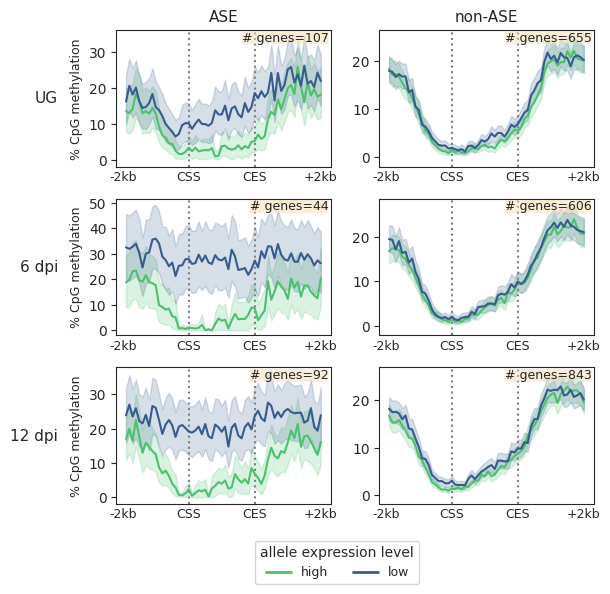

In [166]:
plot_methylation_density(seceff_meth_results_dict, ["UG", "dpi6", "dpi12"], "ASE_secretome_methylation.svg")

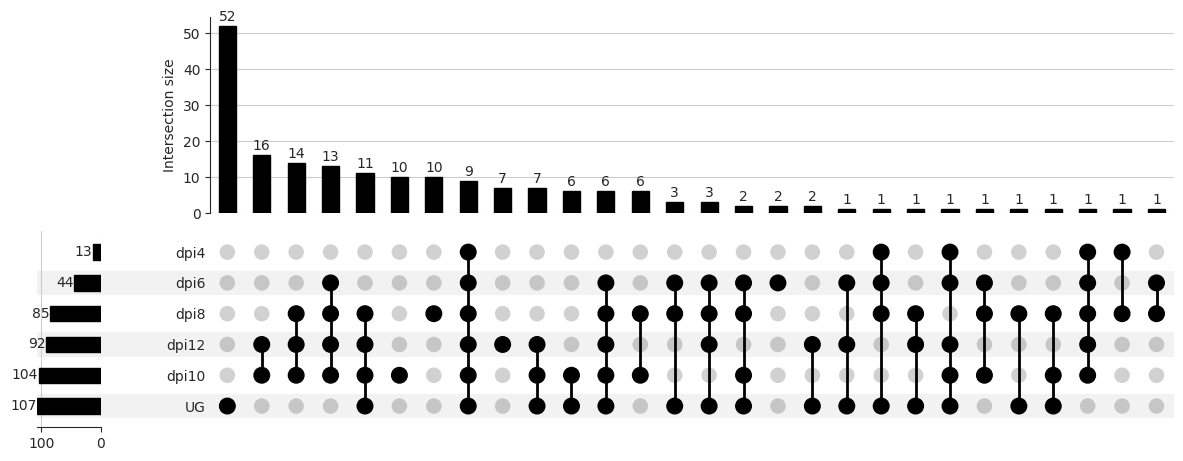

In [170]:
seceff_ase_df = {"UG":seceff_ug_ASE_genes, "dpi4":seceff_dpi4_ASE_genes, "dpi6":seceff_dpi6_ASE_genes,
     "dpi8":seceff_dpi8_ASE_genes, "dpi10":seceff_dpi10_ASE_genes, "dpi12":seceff_dpi12_ASE_genes}
seceff_ase_df_upset = from_contents(seceff_ase_df)
UpSet(seceff_ase_df_upset, sort_by="cardinality", show_counts="{:,}").plot()
len(list(set([x for xs in seceff_ase_df.values() for x in xs])))
plt.savefig("ASE_secretome_profile_upsetplot.svg", format="svg", dpi=600, bbox_inches="tight")

In [ ]:
list(set([x for xs in seceff_ase_df.values() for x in xs]))

In [523]:
a = list(set([x for xs in seceff_ase_df.values() for x in xs]))
b = list(set([x for xs in seceff_nonase_df.values() for x in xs]))
b = list(set(b) - set(a))
len(b)

746

In [524]:
a = list(set([x for xs in busco_ase_df.values() for x in xs]))
b = list(set([x for xs in busco_nonase_df.values() for x in xs]))
b = list(set(b) - set(a))
len(b)

1183

In [546]:
seceff_meth_results_dict["seceff_ASE_UG_alleles"]["bin_id"].unique()

array([20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,
        3,  2,  1, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27,
       26, 25, 24, 23, 22, 21, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50,
       49, 48, 47, 46, 45, 44, 43, 42, 41])

In [385]:
for n in ["UG", "dpi4", "dpi6", "dpi8", "dpi10", "dpi12"]:
    df = seceff_meth_results_dict[f"seceff_ASE_{n}_alleles"]
    tss = df[df["bin_id"] == 20]
    high = tss[tss["status"] != "alt"]["methylation_density"]
    low = tss[tss["status"] == "alt"]["methylation_density"]
    print(n, high.mean()*100, low.mean()*100, low.mean()*100-high.mean()*100)

UG 3.3138454136760127 10.099581289288311 6.785735875612298
dpi4 2.0269382650000005 36.13560708205128 34.10866881705128
dpi6 1.0890540266666666 27.971118072651514 26.882064045984848
dpi8 1.567286780849673 22.310418045409893 20.74313126456022
dpi10 2.505376172083333 19.934251429017856 17.42887525693452
dpi12 2.3811895332608697 19.18847936210145 16.80728982884058


In [557]:
for n in ["UG", "dpi4", "dpi6", "dpi8", "dpi10", "dpi12"]:
    df = seceff_meth_results_dict[f"seceff_nonASE_{n}_alleles"]
    tss = df[df["bin_id"] == 20]
    high = tss[tss["status"] != "alt"]["methylation_density"]
    low = tss[tss["status"] == "alt"]["methylation_density"]
    print(n, high.mean()*100, low.mean()*100, low.mean()*100-high.mean()*100)

UG 1.5247886015527026 1.882542038517721 0.3577534369650184
dpi4 1.1984124163282828 2.991271506661836 1.792859090333553
dpi6 1.600225011203737 2.1843986194405485 0.5841736082368114
dpi8 1.4751464468967472 2.4324013205974215 0.9572548737006743
dpi10 1.3897755102836273 2.4249620007839443 1.035186490500317
dpi12 1.3052520447437115 2.9618023047459707 1.6565502600022592


In [558]:
1.8825+2.9912+2.1843+2.4324+2.4249+2.9618

14.877099999999999

In [559]:
14.877099999999999/6

2.4795166666666666

seceff_ASE_UG_alleles
category
differentially expressed allele    6420
reference allele                   6420
Name: count, dtype: int64


seceff_nonASE_UG_alleles
category
higher expression allele    39300
lower expression allele     39300
Name: count, dtype: int64


seceff_ASE_dpi4_alleles
category
differentially expressed allele    780
reference allele                   780
Name: count, dtype: int64


seceff_nonASE_dpi4_alleles
category
lower expression allele     20700
higher expression allele    20700
Name: count, dtype: int64


seceff_ASE_dpi6_alleles
category
differentially expressed allele    2640
reference allele                   2640
Name: count, dtype: int64


seceff_nonASE_dpi6_alleles
category
lower expression allele     36360
higher expression allele    36360
Name: count, dtype: int64


seceff_ASE_dpi8_alleles
category
differentially expressed allele    5100
reference allele                   5100
Name: count, dtype: int64


seceff_nonASE_dpi8_alleles
category
higher exp

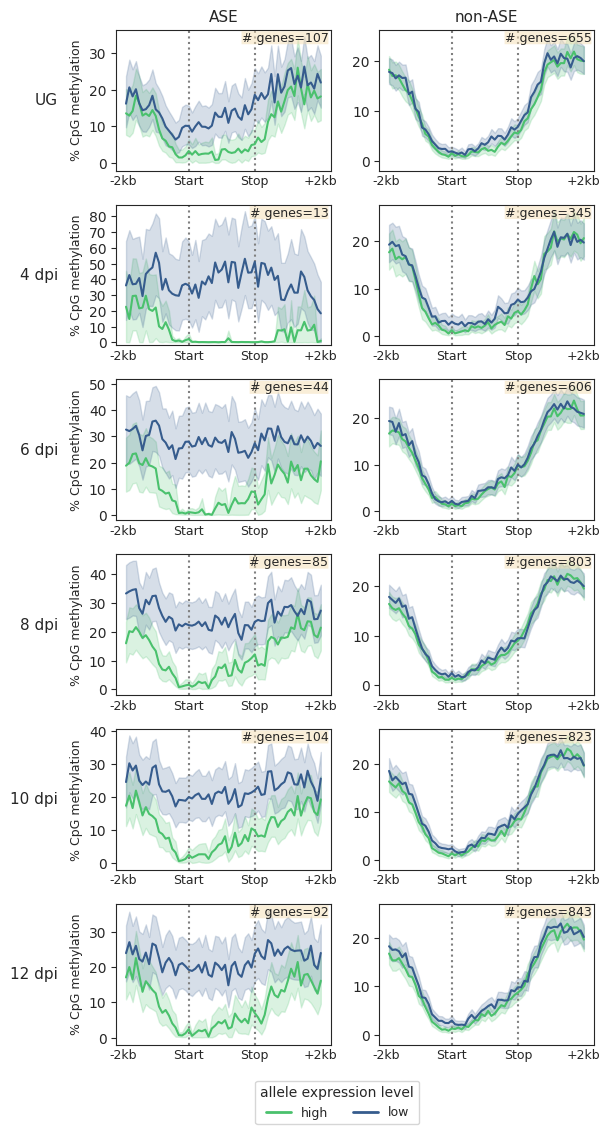

In [172]:
plot_methylation_density(seceff_meth_results_dict, ["UG", "dpi4", "dpi6", "dpi8", "dpi10", "dpi12"],"ASE_secretome_methylation_allConditions.svg")

busco_ASE_UG_alleles
category
reference allele                   840
differentially expressed allele    840
Name: count, dtype: int64


busco_nonASE_UG_alleles
category
higher expression allele    71820
lower expression allele     71820
Name: count, dtype: int64


busco_ASE_dpi6_alleles
category
differentially expressed allele    720
reference allele                   720
Name: count, dtype: int64


busco_nonASE_dpi6_alleles
category
lower expression allele     71880
higher expression allele    71880
Name: count, dtype: int64


busco_ASE_dpi12_alleles
category
differentially expressed allele    540
reference allele                   540
Name: count, dtype: int64


busco_nonASE_dpi12_alleles
category
lower expression allele     72120
higher expression allele    72120
Name: count, dtype: int64




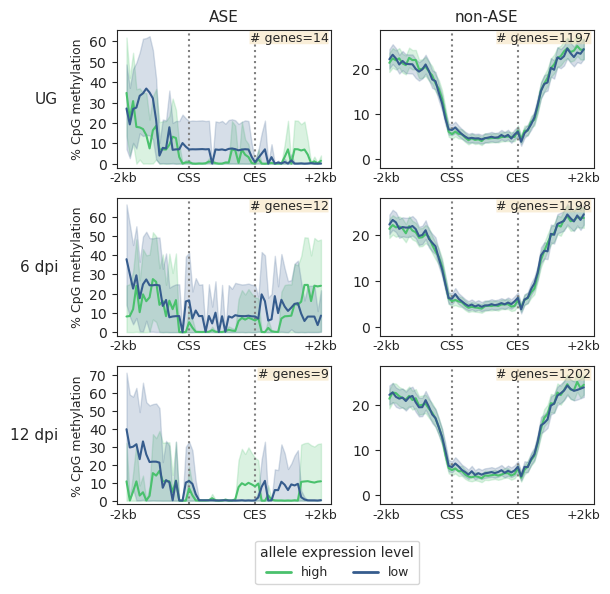

In [538]:
plot_methylation_density(busco_meth_results_dict, ["UG", "dpi6", "dpi12"])

### TE occupancy

In [196]:
## this version groups Diff2 and Diff4

def get_TE_occupancy(feat_coords_bed, filt_deseq2_df, TEoverlap_5prime_bed, TEoverlap_3prime_bed, plot_title, svg_path):
    feat_coords_df = pd.read_csv(feat_coords_bed, sep="\t", header=None)
    feat_coords_df.columns = ["chr", "start", "end", "name", "score", "strand", "gene_id"]
    ase_dict, upreg, alt = get_upreg_to_alt_allele_pair_dict(filt_deseq2_df)
    classified = classify_upreg_alt_in_allele_bed_df(feat_coords_df, ase_dict, filt_deseq2_df)
    classified["category"] = classified["status"].apply(lambda x: "High" if x.startswith("Diff") else "Low")
    results = []
    for i, n in enumerate([TEoverlap_5prime_bed, TEoverlap_3prime_bed]):
        df = pd.read_csv(n, sep="\t", header=None, usecols=(0, 1, 2, 3, 8, 9, 10))
        df.columns = ["chr", "feat_start", "feat_end", "gene", "te_start", "te_end", "te_overlap_bp"]
        df["TE_occupancy"] = (df["te_overlap_bp"] / 2000) * 100
        df = df.groupby(["gene"])["TE_occupancy"].sum().reset_index()
        df = pd.merge(df[["gene", "TE_occupancy"]], classified[["gene", "chr", "start", "end", "status", "category", "abs_log2FoldChange"]], how="right", on="gene").fillna(0)
        df["site"] = "5" if i == 0 else "3"
        results.append(df)
    results = pd.concat(results)
    print(f'Number of Low alleles: {len(results[results["category"]=="Low"])}\n', f'Number of High alleles: {len(results[results["category"]=="High"])}')

    fig, axs = plt.subplots(1, 2, figsize=(4, 3.4), sharey=True)
    five_color = sns.color_palette("Purples", 6)[-2]
    three_color = sns.color_palette("Blues_d", 6)[1]
    sns.violinplot(data=results[results["site"] == "5"], x="category", y="TE_occupancy", hue="site", orient="v", linecolor="k", linewidth=.8, 
                   palette={"5": five_color}, order=["Low", "High"], ax=axs[0], cut=0)
    sns.violinplot(data=results[results["site"] == "3"], x="category", y="TE_occupancy", hue="site", orient="v", linecolor="k", linewidth=.8, 
                   palette={"3": three_color}, order=["Low", "High"], ax=axs[1], cut=0)
    
    for ax in axs:
        ax.set_xlabel("")
        ax.set_ylabel("% TE occupancy")
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
        ax.get_legend().remove()
        ax.set_ylim(None, 145)
    axs[1].tick_params(axis='y', which='both', left=False, labelleft=False)
    
    stats_test = test_TE_occupancy_difference(results)
    categories = ["Low", "High"]
    comparisons = [("Low vs High", 0, 1)]
    def annotate_comparisons(ax, y_max, site, categories, comparisons):
        for label, i, j in comparisons:
            y_max += 20
            y_pos = y_max + 4
            p_value = stats_test[site][f"{categories[i]} vs {categories[j]}"]["p-value"]
            p_value_str = f"NS, p={p_value:.3f}" if p_value >= 0.05 else f"{p_value:.3f}"
            x_pos1, x_pos2 = i, j
            ax.plot([x_pos1, x_pos1, x_pos2, x_pos2], [y_max, y_pos, y_pos, y_max], color='black', lw=1)
            ax.text((x_pos1 + x_pos2) / 2, y_pos + 1, p_value_str, ha='center', va='bottom', fontsize=9)
    y_max = results["TE_occupancy"].max() * 1.05
    annotate_comparisons(axs[0], y_max, "5", categories, comparisons)
    annotate_comparisons(axs[1], y_max, "3", categories, comparisons)
    handles = [patches.Patch(color=five_color, edgecolor='black', label="5' upstream 2kbp"), 
               patches.Patch(color=three_color, edgecolor='black', label="3' downstream 2kbp")]
    fig.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.27, 0), ncol=1, fontsize=9, title="Flank region")
    
    # Add x-axis title in the middle
    fig.text(0.5, 0.02, "Allele expression level", ha="center", va="center", fontsize=10)
    
    plt.yticks(range(0, 141, 20)[:-2])
    plt.tight_layout()
    fig.suptitle(plot_title, fontsize=10, x=0.56, y=1.02)
    if svg_path is not None:
        plt.savefig(svg_path, format="svg", dpi=600, bbox_inches="tight")
    plt.show()
    return results


def test_TE_occupancy_difference(df):
    df_5prime = df[df["site"] == "5"]
    df_3prime = df[df["site"] == "3"]
    categories = ["Low", "High"]
    
    def perform_tests(df_site):
        results = {}
        for i in range(len(categories)):
            for j in range(i + 1, len(categories)):
                cat1 = categories[i]
                cat2 = categories[j]
                group1 = df_site[df_site["category"] == cat1]["TE_occupancy"]
                group2 = df_site[df_site["category"] == cat2]["TE_occupancy"]
                u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative="two-sided")
                results[f"{cat1} vs {cat2}"] = {"u-stat": u_stat, "p-value": p_val}
        return results
    test_results_5prime = perform_tests(df_5prime)
    test_results_3prime = perform_tests(df_3prime)
    combined_results = {"5": test_results_5prime, "3": test_results_3prime}
    for site, results in combined_results.items():
        for comparison, result in results.items():
            p_value = result["p-value"]
            p_value_str = f"NS, p={p_value:.3f}" if p_value >= 0.05 else f"{p_value:.3f}"
            print(f"  {comparison}: u-stat = {result['u-stat']:.3f}, p-value = {p_value}")

    return combined_results


In [ ]:
# def get_TE_occupancy(feat_coords_bed, filt_deseq2_df, TEoverlap_5prime_bed, TEoverlap_3prime_bed, plot_title):
#     feat_coords_df = pd.read_csv(feat_coords_bed, sep="\t", header=None)
#     feat_coords_df.columns = ["chr", "start", "end", "name", "score", "strand", "gene_id"]
#     ase_dict, upreg, alt = get_upreg_to_alt_allele_pair_dict(filt_deseq2_df)
#     classified = classify_upreg_alt_in_allele_bed_df(feat_coords_df, ase_dict, filt_deseq2_df)
#     classified["category"] = classified["status"].apply(lambda x: "DE allele" if x.startswith("|lfc|") else "reference allele")
#     results = []
    
#     for i, n in enumerate([TEoverlap_5prime_bed, TEoverlap_3prime_bed]):
#         df = pd.read_csv(n, sep="\t", header=None, usecols=(0,1,2,3,8,9,10))
#         df.columns = ["chr", "feat_start", "feat_end", "gene", "te_start", "te_end", "te_overlap_bp"]
#         df["TE_occupancy"] = (df["te_overlap_bp"]/2000)*100
#         df = df.groupby(["gene"])["TE_occupancy"].sum().reset_index()
#         df = pd.merge(df[["gene", "TE_occupancy"]], classified[["gene","chr","start","end", "status","category","abs_log2FoldChange"]], how="right", on="gene").fillna(0)
#         df["site"] = "5" if i == 0 else "3"
#         results.append(df)
#     results = pd.concat(results)
#     stats_test = test_TE_occupancy_difference(results)
    
#     plt.figure(figsize=(2.2,3.4))
#     five_color = sns.color_palette("Purples",6)[-2]
#     three_color = sns.color_palette("Blues_d",6)[1]
#     sns.boxplot(data=results, x="category", y="TE_occupancy", hue="site", orient="v", palette={"5":five_color, "3":three_color},
#                 order=["reference allele", "DE allele"])
#     plt.xticks(ticks=[0, 1], labels=["reference", "differentially\nexpressed"])
#     plt.xlabel("allele category")
    
#     handles, labels = plt.gca().get_legend_handles_labels()
#     labels_dict = {"5": "5' 2kbp", "3": "3' 2kbp"}
#     new_labels = [labels_dict.get(label, label) for label in labels]
#     plt.legend(handles, new_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="flank sites")
    
#     p_val_5prime = stats_test["5"]["p-value"]
#     p_val_3prime = stats_test["3"]["p-value"]
#     p_val_5prime = "NS" if p_val_5prime >= 0.05 else f"{p_val_5prime:.2}"
#     p_val_3prime = "NS" if p_val_3prime >= 0.05 else f"{p_val_3prime:.2}"
#     y_max = results["TE_occupancy"].max() * 1.09
#     y_buffer = y_max * 0.04
#     plt.plot([-0.2,-0.2,0.8,0.8], [y_max, y_max+y_buffer, y_max+y_buffer,y_max], lw=1, color="black")
#     plt.text(0.32, y_max+y_buffer+(y_buffer*0.2), p_val_5prime, ha='center', fontsize=9)
#     y_max += 8
#     plt.plot([0.2,0.2,1.2,1.2], [y_max, y_max+y_buffer, y_max+y_buffer,y_max], lw=1, color='black')
#     plt.text(0.7, y_max+y_buffer+(y_buffer*0.2), p_val_5prime, ha='center', fontsize=9)
#     plt.yticks(range(0,141,20)[:-2])
#     plt.ylabel("% TE occupancy")
#     plt.title(plot_title, fontsize=10)
#     return results, stats_test


# def test_TE_occupancy_difference(df):
#     df_5prime = df[df["site"] == "5"]
#     df_3prime = df[df["site"] == "3"]
    
#     ref_allele_5prime = df_5prime[df_5prime["category"] == "reference allele"]["TE_occupancy"]
#     de_allele_5prime = df_5prime[df_5prime["category"] == "DE allele"]["TE_occupancy"]
#     ref_allele_3prime = df_3prime[df_3prime["category"] == "reference allele"]["TE_occupancy"]
#     de_allele_3prime = df_3prime[df_3prime["category"] == "DE allele"]["TE_occupancy"]

#     rank_stat_5prime, p_val_5prime = stats.ranksums(ref_allele_5prime, de_allele_5prime)
#     rank_stat_3prime, p_val_3prime = stats.ranksums(ref_allele_3prime, de_allele_3prime)
#     test_result = {
#         "5": {"rank-stat": rank_stat_5prime, "p-value": p_val_5prime},
#         "3": {"rank-stat": rank_stat_3prime, "p-value": p_val_3prime}}
#     print(test_result)
#     return test_result

In [623]:
# ## this version separates DE genes into Diff2 and Diff4

# def get_TE_occupancy(feat_coords_bed, filt_deseq2_df, TEoverlap_5prime_bed, TEoverlap_3prime_bed, plot_title):
#     feat_coords_df = pd.read_csv(feat_coords_bed, sep="\t", header=None)
#     feat_coords_df.columns = ["chr", "start", "end", "name", "score", "strand", "gene_id"]
#     ase_dict, upreg, alt = get_upreg_to_alt_allele_pair_dict(filt_deseq2_df)
#     classified = classify_upreg_alt_in_allele_bed_df(feat_coords_df, ase_dict, filt_deseq2_df)
#     classified["category"] = classified["status"].apply(lambda x: x if x.startswith("Diff") else "ref")
#     results = []
#     for i, n in enumerate([TEoverlap_5prime_bed, TEoverlap_3prime_bed]):
#         df = pd.read_csv(n, sep="\t", header=None, usecols=(0,1,2,3,8,9,10))
#         df.columns = ["chr", "feat_start", "feat_end", "gene", "te_start", "te_end", "te_overlap_bp"]
#         df["TE_occupancy"] = (df["te_overlap_bp"]/2000)*100
#         df = df.groupby(["gene"])["TE_occupancy"].sum().reset_index()
#         df = pd.merge(df[["gene", "TE_occupancy"]], classified[["gene","chr","start","end", "status","category","abs_log2FoldChange"]], how="right", on="gene").fillna(0)
#         df["site"] = "5" if i == 0 else "3"
#         results.append(df)
#     results = pd.concat(results)
    
#     fig, axs = plt.subplots(1, 2, figsize=(4, 3.4), sharey=True)
#     five_color = sns.color_palette("Purples",6)[-2]
#     three_color = sns.color_palette("Blues_d",6)[1]
#     sns.violinplot(data=results[results["site"] == "5"], x="category", y="TE_occupancy", hue="site", orient="v", linecolor="k", linewidth=.8, 
#                  palette={"5": five_color}, order=["ref", "Diff2", "Diff4"], ax=axs[0])
#     sns.violinplot(data=results[results["site"] == "3"], x="category", y="TE_occupancy", hue="site", orient="v", linecolor="k", linewidth=.8, 
#                  palette={"3": three_color}, order=["ref", "Diff2", "Diff4"], ax=axs[1])
#     for ax in axs:
#         ax.set_xlabel("")
#         ax.set_ylabel("% TE occupancy")
#         ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
#         ax.get_legend().remove()
#         ax.set_ylim(None,140)
#     axs[1].tick_params(axis='y', which='both', left=False, labelleft=False)
    
#     stats_test = test_TE_occupancy_difference(results)
#     categories = ["ref", "Diff2", "Diff4"]
#     comparisons = [("ref vs Diff2", 0, 1),("ref vs Diff4", 0, 2),("Diff2 vs Diff4", 1, 2)]
#     def annotate_comparisons(ax, y_max, site, categories, comparisons):
#         for label, i, j in comparisons:
#             y_pos = y_max+3  
#             p_value = stats_test[site][f"{categories[i]} vs {categories[j]}"]["p-value"]
#             p_value_str = "NS" if p_value >= 0.05 else f"{p_value:.3f}"
#             x_pos1, x_pos2 = i, j
#             ax.plot([x_pos1, x_pos1, x_pos2, x_pos2], [y_max, y_pos, y_pos, y_max], color='black', lw=1)
#             ax.text((x_pos1 + x_pos2)/2, y_pos+4, p_value_str, ha='center', va='bottom', fontsize=9)
#             y_max += 11.5
#     y_max = results["TE_occupancy"].max() * 1.05
#     annotate_comparisons(axs[0], y_max, "5", categories, comparisons)
#     annotate_comparisons(axs[1], y_max, "3", categories, comparisons)
#     handles = [patches.Patch(color=five_color, edgecolor='black', label="5' upstream 2kbp"), 
#                patches.Patch(color=three_color, edgecolor='black', label="3' downstream 2kbp")]
#     fig.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.27, 0), ncol=1, fontsize=9, title="flank region")
#     plt.yticks(range(0, 141, 20)[:-2])
#     plt.tight_layout()
#     # fig.subplots_adjust(top=0.9)
#     fig.suptitle(plot_title, fontsize=10, x=0.56, y=1.02)
#     plt.show()
#     return results



# def test_TE_occupancy_difference(df):
#     df_5prime = df[df["site"] == "5"]
#     df_3prime = df[df["site"] == "3"]
#     categories = ["ref", "Diff2", "Diff4"]
#     def perform_tests(df_site):
#         results = {}
#         for i in range(len(categories)):
#             for j in range(i + 1, len(categories)):
#                 cat1 = categories[i]
#                 cat2 = categories[j]
#                 group1 = df_site[df_site["category"] == cat1]["TE_occupancy"]
#                 group2 = df_site[df_site["category"] == cat2]["TE_occupancy"]
#                 rank_stat, p_val = stats.ranksums(group1, group2)
#                 results[f"{cat1} vs {cat2}"] = {"rank-stat": rank_stat, "p-value": p_val}
#         return results
#     test_results_5prime = perform_tests(df_5prime)
#     test_results_3prime = perform_tests(df_3prime)
#     combined_results = {"5": test_results_5prime,"3": test_results_3prime}
#     for site, results in combined_results.items():
#         print(f"Site {site}:")
#         for comparison, result in results.items():
#             p_value = result["p-value"]
#             p_value_str = "NS" if p_value >= 0.05 else f"{p_value:.3f}"
#             print(f"  {comparison}: rank-stat = {result['rank-stat']:.3f}, p-value = {p_value}")
#     return combined_results

In [617]:
# generate_genebody_and_5_3_flank_cooordinates(ug_ASE["allele_pair"], cds_gff3, "genes_ASE_UG")
# generate_genebody_and_5_3_flank_cooordinates(dpi4_ASE["allele_pair"], cds_gff3, "genes_ASE_dpi4")
# generate_genebody_and_5_3_flank_cooordinates(dpi6_ASE["allele_pair"], cds_gff3, "genes_ASE_dpi6")
# generate_genebody_and_5_3_flank_cooordinates(dpi8_ASE["allele_pair"], cds_gff3, "genes_ASE_dpi8")
# generate_genebody_and_5_3_flank_cooordinates(dpi10_ASE["allele_pair"], cds_gff3, "genes_ASE_dpi10")
# generate_genebody_and_5_3_flank_cooordinates(dpi12_ASE["allele_pair"], cds_gff3, "genes_ASE_dpi12")
# generate_genebody_and_5_3_flank_cooordinates(ug_nonASE["allele_pair"], cds_gff3, "genes_nonASE_UG")
# generate_genebody_and_5_3_flank_cooordinates(dpi4_nonASE["allele_pair"], cds_gff3, "genes_nonASE_dpi4")
# generate_genebody_and_5_3_flank_cooordinates(dpi6_nonASE["allele_pair"], cds_gff3, "genes_nonASE_dpi6")
# generate_genebody_and_5_3_flank_cooordinates(dpi8_nonASE["allele_pair"], cds_gff3, "genes_nonASE_dpi8")
# generate_genebody_and_5_3_flank_cooordinates(dpi10_nonASE["allele_pair"], cds_gff3, "genes_nonASE_dpi10")
# generate_genebody_and_5_3_flank_cooordinates(dpi12_nonASE["allele_pair"], cds_gff3, "genes_nonASE_dpi12")

Number of Low alleles: 812
 Number of High alleles: 812
  Low vs High: u-stat = 77723.500, p-value = 0.14533247803565372
  Low vs High: u-stat = 80545.500, p-value = 0.5642032239936055


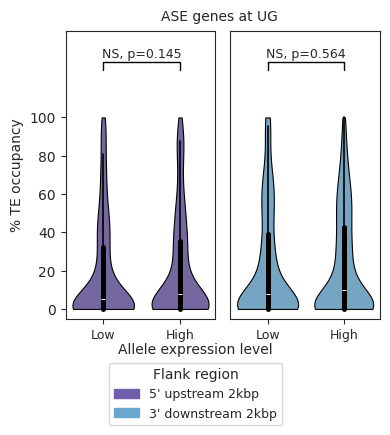

Number of Low alleles: 148
 Number of High alleles: 148
  Low vs High: u-stat = 2530.500, p-value = 0.41505268644215976
  Low vs High: u-stat = 2750.000, p-value = 0.9644965572224548


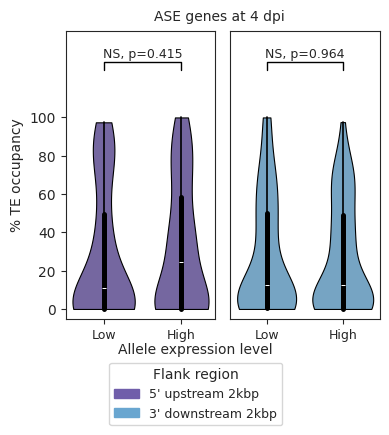

Number of Low alleles: 410
 Number of High alleles: 410
  Low vs High: u-stat = 19493.500, p-value = 0.19238734057417928
  Low vs High: u-stat = 21760.500, p-value = 0.5246934987858398


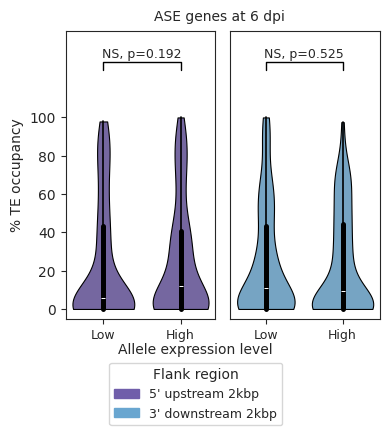

Number of Low alleles: 300
 Number of High alleles: 300
  Low vs High: u-stat = 10419.000, p-value = 0.2602047319225128
  Low vs High: u-stat = 11546.000, p-value = 0.6885391731502557


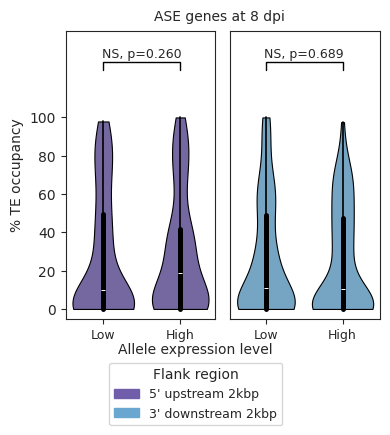

Number of Low alleles: 600
 Number of High alleles: 600
  Low vs High: u-stat = 45807.000, p-value = 0.6985932624731408
  Low vs High: u-stat = 45987.500, p-value = 0.6346530169361511


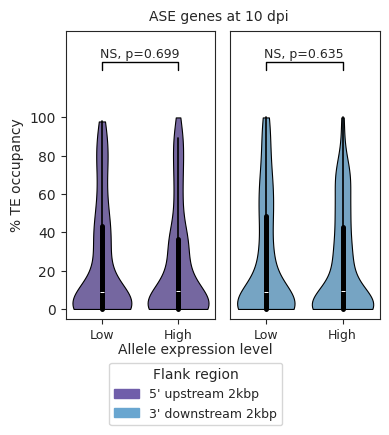

Number of Low alleles: 584
 Number of High alleles: 584
  Low vs High: u-stat = 42406.500, p-value = 0.9101969061368345
  Low vs High: u-stat = 42712.500, p-value = 0.9680518235368962


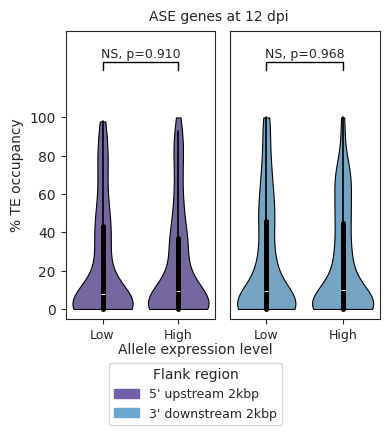

In [226]:
genes_ASE_ug = get_TE_occupancy("genes_ASE_UG.genebody.coords.bed", ug_ASE,
                                "TE_occupancy/genes_ASE_UG.5prime_2000bp.TEoverlap.bed",
                                "TE_occupancy/genes_ASE_UG.3prime_2000bp.TEoverlap.bed",
                                 "ASE genes at UG", "ASE_allGenes_TE_occupancy_UG.svg")
genes_ASE_dpi10 = get_TE_occupancy("genes_ASE_dpi4.genebody.coords.bed", dpi4_ASE,
                                   "TE_occupancy/genes_ASE_dpi4.5prime_2000bp.TEoverlap.bed",
                                   "TE_occupancy/genes_ASE_dpi4.3prime_2000bp.TEoverlap.bed",
                                   "ASE genes at 4 dpi", "ASE_allGenes_TE_occupancy_dpi4.svg")
genes_ASE_dpi10 = get_TE_occupancy("genes_ASE_dpi6.genebody.coords.bed", dpi6_ASE,
                                   "TE_occupancy/genes_ASE_dpi6.5prime_2000bp.TEoverlap.bed",
                                   "TE_occupancy/genes_ASE_dpi6.3prime_2000bp.TEoverlap.bed",
                                   "ASE genes at 6 dpi", "ASE_allGenes_TE_occupancy_dpi6.svg")
genes_ASE_dpi10 = get_TE_occupancy("genes_ASE_dpi8.genebody.coords.bed", dpi6_ASE,
                                   "TE_occupancy/genes_ASE_dpi8.5prime_2000bp.TEoverlap.bed",
                                   "TE_occupancy/genes_ASE_dpi8.3prime_2000bp.TEoverlap.bed",
                                   "ASE genes at 8 dpi", "ASE_allGenes_TE_occupancy_dpi8.svg")
genes_ASE_dpi10 = get_TE_occupancy("genes_ASE_dpi10.genebody.coords.bed", dpi10_ASE,
                                   "TE_occupancy/genes_ASE_dpi10.5prime_2000bp.TEoverlap.bed",
                                   "TE_occupancy/genes_ASE_dpi10.3prime_2000bp.TEoverlap.bed",
                                   "ASE genes at 10 dpi", "ASE_allGenes_TE_occupancy_dpi10.svg")
genes_ASE_dpi12 = get_TE_occupancy("genes_ASE_dpi12.genebody.coords.bed", dpi12_ASE,
                                   "TE_occupancy/genes_ASE_dpi12.5prime_2000bp.TEoverlap.bed",
                                   "TE_occupancy/genes_ASE_dpi12.3prime_2000bp.TEoverlap.bed",
                                   "ASE genes at 12 dpi", "ASE_allGenes_TE_occupancy_dpi12.svg")

Number of Low alleles: 214
 Number of High alleles: 214
  Low vs High: u-stat = 5327.000, p-value = 0.37064997214078765
  Low vs High: u-stat = 5643.000, p-value = 0.8539374717630603


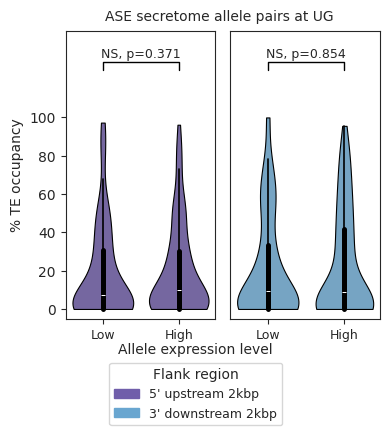

Number of Low alleles: 26
 Number of High alleles: 26
  Low vs High: u-stat = 102.000, p-value = 0.3816877769730641
  Low vs High: u-stat = 104.500, p-value = 0.3164818409988166


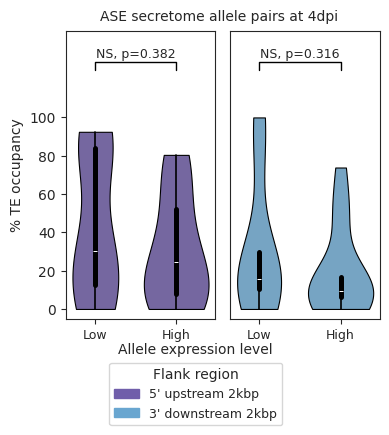

Number of Low alleles: 88
 Number of High alleles: 88
  Low vs High: u-stat = 1011.000, p-value = 0.7210127429807878
  Low vs High: u-stat = 1119.000, p-value = 0.20087816750614318


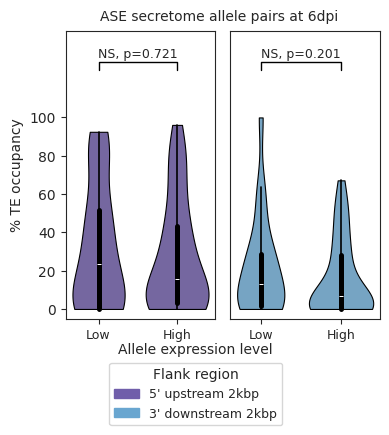

Number of Low alleles: 170
 Number of High alleles: 170
  Low vs High: u-stat = 3935.500, p-value = 0.3109086168640687
  Low vs High: u-stat = 3774.500, p-value = 0.60629717398703


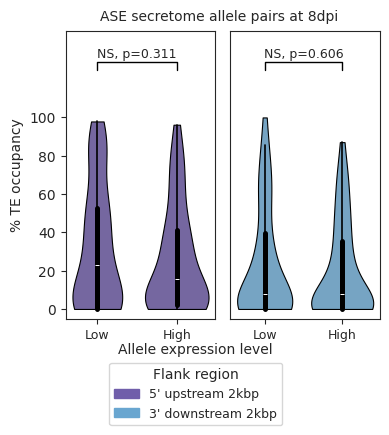

Number of Low alleles: 208
 Number of High alleles: 208
  Low vs High: u-stat = 5960.000, p-value = 0.19780578426686657
  Low vs High: u-stat = 5800.000, p-value = 0.3545456654849628


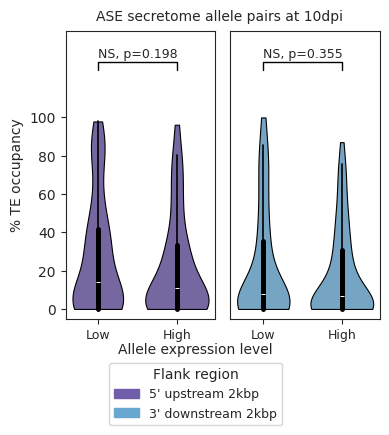

Number of Low alleles: 184
 Number of High alleles: 184
  Low vs High: u-stat = 4565.500, p-value = 0.3481110038072399
  Low vs High: u-stat = 4573.000, p-value = 0.3333729754776751


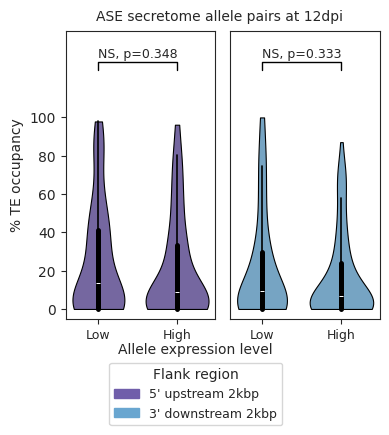

In [197]:
TE_occup_seceff_ASE_UG = get_TE_occupancy("seceff_ASE_UG_alleles.5prime_2000bp.coords.bed", ug_ASE, \
                 'TE_occupancy/seceff_ASE_UG_alleles.5prime_2000bp.TEoverlap.bed',\
                 'TE_occupancy/seceff_ASE_UG_alleles.3prime_2000bp.TEoverlap.bed', "ASE secretome allele pairs at UG", "ASE_secretome_TE_occupancy_UG.svg")
TE_occup_seceff_ASE_dpi4 = get_TE_occupancy("seceff_ASE_dpi4_alleles.5prime_2000bp.coords.bed", dpi4_ASE, \
                 'TE_occupancy/seceff_ASE_dpi4_alleles.5prime_2000bp.TEoverlap.bed',\
                 'TE_occupancy/seceff_ASE_dpi4_alleles.3prime_2000bp.TEoverlap.bed', "ASE secretome allele pairs at 4dpi", "ASE_secretome_TE_occupancy_4dpi.svg")
TE_occup_seceff_ASE_dpi6 = get_TE_occupancy("seceff_ASE_dpi6_alleles.5prime_2000bp.coords.bed", dpi6_ASE, \
                 'TE_occupancy/seceff_ASE_dpi6_alleles.5prime_2000bp.TEoverlap.bed',\
                 'TE_occupancy/seceff_ASE_dpi6_alleles.3prime_2000bp.TEoverlap.bed', "ASE secretome allele pairs at 6dpi", "ASE_secretome_TE_occupancy_6dpi.svg")
TE_occup_seceff_ASE_dpi8 = get_TE_occupancy("seceff_ASE_dpi8_alleles.5prime_2000bp.coords.bed", dpi8_ASE, \
                 'TE_occupancy/seceff_ASE_dpi8_alleles.5prime_2000bp.TEoverlap.bed',\
                 'TE_occupancy/seceff_ASE_dpi8_alleles.3prime_2000bp.TEoverlap.bed', "ASE secretome allele pairs at 8dpi", "ASE_secretome_TE_occupancy_8dpi.svg")
TE_occup_seceff_ASE_dpi10 = get_TE_occupancy("seceff_ASE_dpi10_alleles.5prime_2000bp.coords.bed", dpi10_ASE, \
                 'TE_occupancy/seceff_ASE_dpi10_alleles.5prime_2000bp.TEoverlap.bed',\
                 'TE_occupancy/seceff_ASE_dpi10_alleles.3prime_2000bp.TEoverlap.bed', "ASE secretome allele pairs at 10dpi", "ASE_secretome_TE_occupancy_10dpi.svg")
TE_occup_seceff_ASE_dpi12 = get_TE_occupancy("seceff_ASE_dpi12_alleles.5prime_2000bp.coords.bed", dpi12_ASE, \
                 'TE_occupancy/seceff_ASE_dpi12_alleles.5prime_2000bp.TEoverlap.bed',\
                 'TE_occupancy/seceff_ASE_dpi12_alleles.3prime_2000bp.TEoverlap.bed', "ASE secretome allele pairs at 12dpi", "ASE_secretome_TE_occupancy_12dpi.svg")

### allele sequence divergence

In [201]:
BASEDIR = "/media/ssd/rita/project/104e/allele_analysis"
#interpro_anno_file = "Puccinia_striiformis_Pst104E.iprscan.InterProOnly.tsv"
proteinortho_file = os.path.join(BASEDIR, "allele_identification/output_analysed_alleles_test.df")
# import and clean up allele pairs and stats dataframe
proteinortho = pd.read_csv(proteinortho_file, sep="\t", usecols=range(0,16))

# filter allele pairs by reciprocal matches evalue < 0.05 both ways. this is for checking only, shouldn't change the df.
proteinortho = proteinortho[(proteinortho["evalue_ab"] < 0.05) & (proteinortho["evalue_ba"] < 0.05)]
proteinortho["Target"] = proteinortho["Target"].apply(lambda x: x[:-3])
proteinortho["Query"] = proteinortho["Query"].apply(lambda x: x[:-3])
proteinortho["Index"] = proteinortho["Index"].apply(lambda x: x.replace("-T1_", ",")[:-3])

# remove co-orthologs for one-to-one orthologs to simplify analysis
proteinortho = proteinortho[~proteinortho["Target"].duplicated()]
proteinortho = proteinortho[~proteinortho["Query"].duplicated()]
het_proteinortho = proteinortho[(proteinortho["yn00_dS"] > 0) | (proteinortho["yn00_dN"] > 0)]
het_proteinortho

,Unnamed: 0,Target,Query,evalue_ab,bitscore_ab,evalue_ba,bitscore_ba,same_strand,simscore,Index,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dS,yn00_dN
15,50,Pst104E137_015700,Pst104E137_000068,0.000000e+00,2239.0,0.000000e+00,2239.0,1,1.000000,"Pst104E137_015700,Pst104E137_000068",0.0007,0.0007,0.0002,0.0002,0.0000,0.0003
19,64,Pst104E137_015721,Pst104E137_000089,8.780000e-79,289.0,1.120000e-78,289.0,1,1.000000,"Pst104E137_015721,Pst104E137_000089",0.2290,0.2290,0.2259,0.2259,0.0000,0.0030
20,65,Pst104E137_015723,Pst104E137_000092,3.600000e-41,163.0,3.570000e-41,163.0,1,0.606683,"Pst104E137_015723,Pst104E137_000092",0.0125,0.0125,0.0042,0.0042,0.0000,0.0062
26,82,Pst104E137_015745,Pst104E137_000113,4.270000e-67,250.0,4.240000e-67,250.0,1,0.995567,"Pst104E137_015745,Pst104E137_000113",0.0068,0.0068,0.0023,0.0023,0.0000,0.0033
27,83,Pst104E137_015746,Pst104E137_000114,1.140000e-39,158.0,1.130000e-39,158.0,1,0.584175,"Pst104E137_015746,Pst104E137_000114",0.0127,0.0127,0.0042,0.0042,0.0000,0.0056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10888,5826,Pst104E137_023677,Pst104E137_008169,0.000000e+00,2506.0,0.000000e+00,2506.0,1,1.000000,"Pst104E137_023677,Pst104E137_008169",0.0000,0.0000,0.0003,0.0003,0.0008,0.0000
10889,726,Pst104E137_016604,Pst104E137_000990,0.000000e+00,2850.0,0.000000e+00,2850.0,1,1.000000,"Pst104E137_016604,Pst104E137_000990",0.0000,0.0000,0.0002,0.0002,0.0007,0.0000
10890,9732,Pst104E137_029435,Pst104E137_013995,0.000000e+00,3120.0,0.000000e+00,3120.0,1,1.000000,"Pst104E137_029435,Pst104E137_013995",0.0000,0.0000,0.0002,0.0002,0.0007,0.0000
10891,5030,Pst104E137_022568,Pst104E137_007023,0.000000e+00,2869.0,0.000000e+00,2869.0,1,1.000000,"Pst104E137_022568,Pst104E137_007023",0.2325,0.2325,0.2327,0.2327,0.0006,0.0000


Text(0.5, 1.0, 'Heterozygous genes')

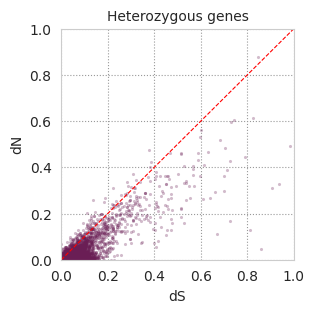

In [95]:
plt.figure(figsize=(3,3))
sns.scatterplot(data=het_proteinortho, x="yn00_dS", y="yn00_dN",  s=5, alpha=0.3, color="#6A1E55", lw=0)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=0.8)
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel("dS")
plt.ylabel("dN")
plt.title("Heterozygous genes", fontsize=10)


In [200]:
het_proteinortho_busco = het_proteinortho[het_proteinortho["Index"].apply(lambda x: any(ids in x.split(",") for ids in busco_gene_id))]
het_proteinortho_seceff = het_proteinortho[het_proteinortho["Index"].apply(lambda x: any(ids in x.split(",") for ids in seceff_gene_id))]

KeyboardInterrupt: 

In [ ]:
len(het_proteinortho_busco)

In [ ]:
len(het_proteinortho_seceff)

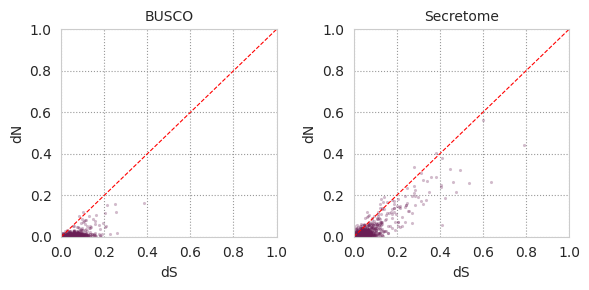

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.scatterplot(data=het_proteinortho_busco, x="yn00_dS", y="yn00_dN", s=5, alpha=0.3, color="#6A1E55", lw=0, ax=ax[0])
ax[0].plot([0, 1], [0, 1], color="red", linestyle="--", lw=0.8)
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("dS")
ax[0].set_ylabel("dN")
ax[0].set_title("BUSCO", fontsize=10)

sns.scatterplot(data=het_proteinortho_seceff, x="yn00_dS", y="yn00_dN", s=5, alpha=0.3, color="#6A1E55", lw=0, ax=ax[1])
ax[1].plot([0, 1], [0, 1], color="red", linestyle="--", lw=0.8)
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 1)
ax[1].set_xlabel("dS")
ax[1].set_ylabel("dN")
ax[1].set_title("Secretome", fontsize=10)

plt.tight_layout()
plt.show()

In [212]:
def assign_distance_to_allelePair_deseq2(deseq2_res_df, proteinortho_df, dNdS=False):
    print(f"length check before padj filter: {len(deseq2_res_df)}")
    deseq2_res_df = deseq2_res_df[deseq2_res_df["padj"]<0.05]
    print(f"length check after padj filter: {len(deseq2_res_df)}")
    
    deseq2_res_df[["alleleA", "alleleB"]] = deseq2_res_df["allele_pair"].str.split(":",expand=True)
    proteinortho_df.rename(columns={"Target": "alleleB", "Query":"alleleA", "yn00_dS":"dS", "yn00_dN":"dN"}, inplace=True)
    result = pd.merge(deseq2_res_df, proteinortho_df[["alleleA","alleleB", "protein_hamming", "protein_levenshtein","cds_hamming","cds_levenshtein","dS","dN"]], on=["alleleA", "alleleB"])
    result["abs_log2FoldChange"] = abs(result["log2FoldChange"])
    
    if dNdS:
        result["log10(dS)"] = np.log10(result["dS"]+1)
        result["log10(dN)"] = np.log10(result["dN"]+1)
        result["dN/dS"] = result["dN"]/result["dS"]
        result["log10(dN/dS)"] = np.log10(result["dN/dS"]+1) 
        nan_count = result["log10(dN/dS)"].isna().sum()
        inf_count = np.isinf(result["log10(dN/dS)"]).sum()
        total_count = nan_count + inf_count
        print("Number of NaN or infinite cells:", total_count)
        result = result.dropna()
    
    else:
        result = result.dropna()
    return result


def assign_secretome_effector_anno(df, effector_gene_id, secretome_gene_id):
    seceff_bool = []
    for _, row in df.iterrows():
        if row["alleleA"] in effector_gene_id or row["alleleB"] in effector_gene_id:
            seceff_bool.append("effector")
        elif row["alleleA"] in secretome_gene_id or row["alleleB"] in secretome_gene_id:
            seceff_bool.append("secretome")
        else:
            seceff_bool.append("others")
        if row["alleleA"] in seceff_gene_id or row["alleleB"] in seceff_gene_id:
            seceff_bool.append("yes")
            seceff_name.append(row["allele_pair"])
        else:
            seceff_bool.append("no")
    df["is_secretome_effector"] = seceff_bool
    print(df["is_secretome_effector"].value_counts())
    return df

def plot_spearman_correlation(df, x_col, y_col):
    spearman_corr, p_value = stats.spearmanr(df[x_col], df[y_col])
    
    plt.figure(figsize=(8, 6))
    sns.regplot(data=df, x=x_col, y=y_col, scatter_kws={"s": 20}, line_kws={"color": "red"}, ci=None)
    
    plt.text(
        0.05, 0.95,
        f"Spearman ρ:{spearman_corr:.2f}\np:{p_value:.2e}",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top'
    )
    
    # Add labels and title
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(plot_title)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

length check before padj filter: 107
length check after padj filter: 107
Number of NaN or infinite cells: 10
length check before padj filter: 13
length check after padj filter: 13
Number of NaN or infinite cells: 3
length check before padj filter: 44
length check after padj filter: 44
Number of NaN or infinite cells: 7
length check before padj filter: 85
length check after padj filter: 85
Number of NaN or infinite cells: 14
length check before padj filter: 104
length check after padj filter: 104
Number of NaN or infinite cells: 11
length check before padj filter: 92
length check after padj filter: 92
Number of NaN or infinite cells: 9


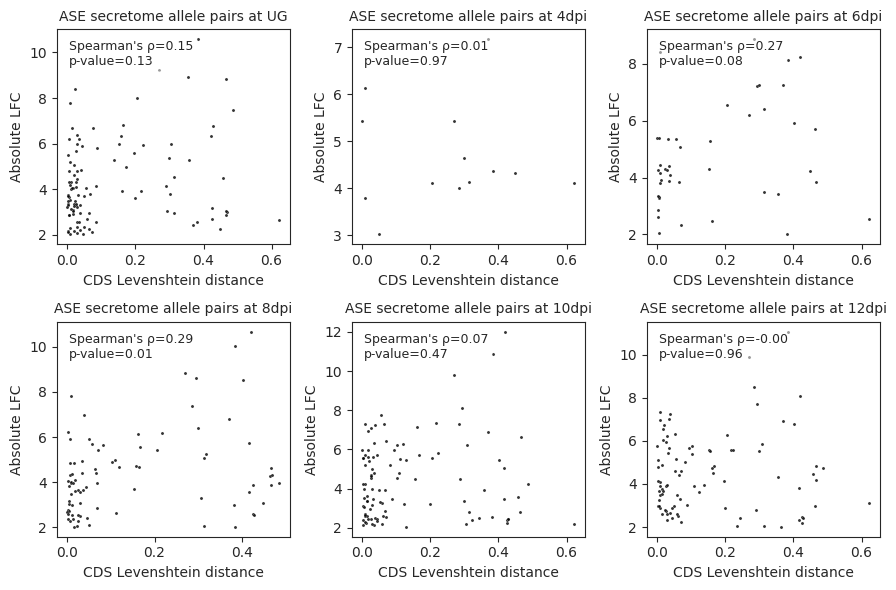

In [233]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6))

datasets = [
    ("ASE secretome allele pairs at UG", ug_deseq2_df[ug_deseq2_df["allele_pair"].isin(seceff_ug_ASE_genes)], ax[0, 0]),
    ("ASE secretome allele pairs at 4dpi",dpi4_deseq2_df[dpi4_deseq2_df["allele_pair"].isin(seceff_dpi4_ASE_genes)], ax[0, 1]),
    ("ASE secretome allele pairs at 6dpi",dpi6_deseq2_df[dpi6_deseq2_df["allele_pair"].isin(seceff_dpi6_ASE_genes)], ax[0, 2]),
    ("ASE secretome allele pairs at 8dpi",dpi8_deseq2_df[dpi8_deseq2_df["allele_pair"].isin(seceff_dpi8_ASE_genes)], ax[1, 0]),
    ("ASE secretome allele pairs at 10dpi",dpi10_deseq2_df[dpi10_deseq2_df["allele_pair"].isin(seceff_dpi10_ASE_genes)], ax[1, 1]),
    ("ASE secretome allele pairs at 12dpi",dpi12_deseq2_df[dpi12_deseq2_df["allele_pair"].isin(seceff_dpi12_ASE_genes)], ax[1, 2]),
]

for title, data, subplot in datasets:
    result = assign_distance_to_allelePair_deseq2(data, het_proteinortho, dNdS=True)
    sns.scatterplot(
        data=result,
        x="cds_levenshtein",
        y="abs_log2FoldChange",
        ax=subplot,
        s=5,
        alpha=0.8,
        color="k"
    )
    
    # Calculate Spearman correlation
    spearman_corr, p_value = stats.spearmanr(result["cds_levenshtein"], result["abs_log2FoldChange"])
    subplot.set_title(title, fontsize=10)
    # Annotate with correlation and p-value
    subplot.text(
        0.05, 0.95,
        f"Spearman's ρ={spearman_corr:.2f}\np-value={p_value:.2f}",
        transform=subplot.transAxes,
        fontsize=9,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
    subplot.set_xlabel("CDS Levenshtein distance")
    subplot.set_ylabel("Absolute LFC")
    

# Add overall figure labels and adjust layout
plt.tight_layout()
plt.savefig("ASE_secretome_CDS_levenshtein_distance.svg", format="svg", dpi=600, bbox_inches="tight")


length check before padj filter: 6457
length check after padj filter: 1528
Number of NaN or infinite cells: 68
length check before padj filter: 4955
length check after padj filter: 93
Number of NaN or infinite cells: 8
length check before padj filter: 5956
length check after padj filter: 505
Number of NaN or infinite cells: 27
length check before padj filter: 6457
length check after padj filter: 906
Number of NaN or infinite cells: 55
length check before padj filter: 6457
length check after padj filter: 1092
Number of NaN or infinite cells: 59
length check before padj filter: 6457
length check after padj filter: 1069
Number of NaN or infinite cells: 53


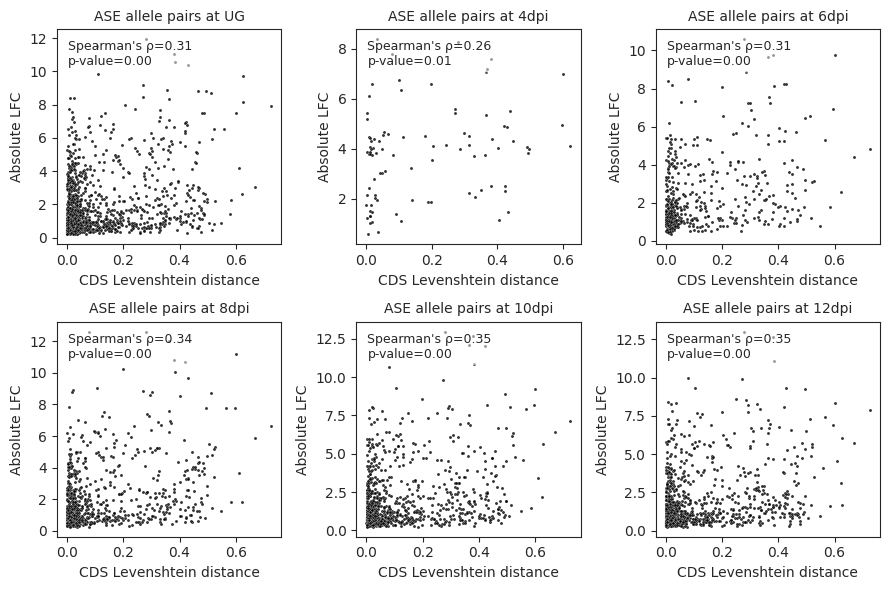

In [234]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6))

datasets = [
    ("ASE allele pairs at UG", ug_deseq2_df, ax[0, 0]),
    ("ASE allele pairs at 4dpi",dpi4_deseq2_df, ax[0, 1]),
    ("ASE allele pairs at 6dpi",dpi6_deseq2_df, ax[0, 2]),
    ("ASE allele pairs at 8dpi",dpi8_deseq2_df, ax[1, 0]),
    ("ASE allele pairs at 10dpi",dpi10_deseq2_df, ax[1, 1]),
    ("ASE allele pairs at 12dpi",dpi12_deseq2_df, ax[1, 2]),
]

for title, data, subplot in datasets:
    result = assign_distance_to_allelePair_deseq2(data, het_proteinortho, dNdS=True)
    sns.scatterplot(
        data=result,
        x="cds_levenshtein",
        y="abs_log2FoldChange",
        ax=subplot,
        s=5,
        alpha=0.8,
        color="k"
    )
    
    # Calculate Spearman correlation
    spearman_corr, p_value = stats.spearmanr(result["cds_levenshtein"], result["abs_log2FoldChange"])
    subplot.set_title(title, fontsize=10)
    # Annotate with correlation and p-value
    subplot.text(
        0.05, 0.95,
        f"Spearman's ρ={spearman_corr:.2f}\np-value={p_value:.2f}",
        transform=subplot.transAxes,
        fontsize=9,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
    subplot.set_xlabel("CDS Levenshtein distance")
    subplot.set_ylabel("Absolute LFC")
    

# Add overall figure labels and adjust layout
plt.tight_layout()
plt.savefig("ASE_allGenes_CDS_levenshtein_distance.svg", format="svg", dpi=600, bbox_inches="tight")
